In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/Share_Data/my_df.csv')
pd.options.display.max_columns = None

# 's_' short for smoke
s_heart_attack = pd.read_csv("/content/drive/MyDrive/Share_Data/Predict_dis/s_ph006d1.csv")
s_heart_attack = s_heart_attack.replace(-1,0)
s_high_blood_presure = pd.read_csv("/content/drive/MyDrive/Share_Data/Predict_dis/s_ph006d2.csv")
s_high_blood_presure = s_high_blood_presure.replace(-1,0)
s_high_blood_cholesterol = pd.read_csv("/content/drive/MyDrive/Share_Data/Predict_dis/s_ph006d3.csv")
s_high_blood_cholesterol = s_high_blood_cholesterol.replace(-1,0)
s_stroke = pd.read_csv("/content/drive/MyDrive/Share_Data/Predict_dis/s_ph006d4.csv")
s_stroke = s_stroke.replace(-1,0)
s_diabetes = pd.read_csv("/content/drive/MyDrive/Share_Data/Predict_dis/s_ph006d5.csv")
s_diabetes = s_diabetes.replace(-1,0)
s_copd = pd.read_csv("/content/drive/MyDrive/Share_Data/Predict_dis/s_ph006d6.csv")
s_copd = s_copd.replace(-1,0)
s_asthma = pd.read_csv("/content/drive/MyDrive/Share_Data/Predict_dis/s_ph006d7.csv")
s_asthma = s_asthma.replace(-1,0)

# without smoking status
heart_attack = pd.read_csv("/content/drive/MyDrive/Share_Data/Predict_dis/ph006d1.csv")
heart_attack = heart_attack.replace(-1,0)
high_blood_presure = pd.read_csv("/content/drive/MyDrive/Share_Data/Predict_dis/ph006d2.csv")
high_blood_presure = high_blood_presure.replace(-1,0)
high_blood_cholesterol = pd.read_csv("/content/drive/MyDrive/Share_Data/Predict_dis/ph006d3.csv")
high_blood_cholesterol = high_blood_cholesterol.replace(-1,0)
stroke = pd.read_csv("/content/drive/MyDrive/Share_Data/Predict_dis/ph006d4.csv")
stroke = stroke.replace(-1,0)
diabetes = pd.read_csv("/content/drive/MyDrive/Share_Data/Predict_dis/ph006d5.csv")
diabetes = diabetes.replace(-1,0)
copd = pd.read_csv("/content/drive/MyDrive/Share_Data/Predict_dis/ph006d6.csv")
copd = copd.replace(-1,0)
asthma = pd.read_csv("/content/drive/MyDrive/Share_Data/Predict_dis/ph006d7.csv")
asthma = asthma.replace(-1,0)


# #pd.reset_option("display.max_rows")
# # Drop people with age less than 60: ???
# #------------------------
# # # convert 'age' column to numeric, converting non-numeric values to NaN
# # df['age'] = pd.to_numeric(df['age'], errors='coerce')
# # df = df[df['age'] >= 60]
# #------------------------
# #!!Very important, the dataframe represents numeric values as strings. We should convert them to numeric values.
# numeric_cols = df.columns.difference(['mergeid', 'country'])
# df[numeric_cols] = df[numeric_cols].applymap(float)

# int_cols = []
# for col in df.columns:
#     # check if all non-null values in the column end with ".0"
#     if df[col][df[col].notnull()].apply(lambda x: str(x).endswith('.0')).all():
#         # convert the non-null values in the column to integer
#         int_cols.append(col)
# df[int_cols] = df[int_cols].astype('Int64')

# df

Mounted at /content/drive


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 29.5 MB/s eta 0:00:00


In [ ]:
#Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(dataframe, independent_var):

    X = dataframe.drop([independent_var, 'Total CM', 'Total PM25', 'Total NOx', 'Total SO', 'br002_', 'br001_', 'ph011d3',
                          'ph048d2', 'ph049d9', 'ph048d3', 'ph049d1', 'ph049d3', 'ph049d4', 'ph011d11',
                          'ph049d5', 'ph049d10', 'ph049d11', 'ph049d6', 'ph049d2', 'ph011d2', 'ph011d1', 'ph011d6',
                          'ph049d8', 'ph011d13', 'ph011d14', 'ph011d7', 'ph011d9', 'ph048d10', 'ph048d7', 'ph048d8',
                          'ph048d9', 'ph049d12', 'ph049d7'], axis=1)
    y = dataframe[independent_var]

    # apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Min-Max normalization
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X_resampled)

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_resampled, test_size=0.2, random_state=42)

    best_f1 = 0
    best_k = None

    # loop through different values of k
    for k in range(1, X_train.shape[1] + 1):
        # perform feature selection using SelectKBest and mutual_info_classif
        selector = SelectKBest(score_func=mutual_info_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        model = LogisticRegression()

        param_grid = {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }

        # grid search cross-validation to find the best hyperparameters
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')
        grid_search.fit(X_train_selected, y_train)

        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test_selected)

        f1 = f1_score(y_test, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_k = k

    print("Best k:", best_k)

    # perform feature selection using the best k value
    selector = SelectKBest(score_func=mutual_info_classif, k=best_k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    best_model = LogisticRegression(**grid_search.best_params_)

    best_model.fit(X_train_selected, y_train)

    y_pred = best_model.predict(X_test_selected)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(confusion_matrix(y_test, y_pred))
    print('-' * 60)
    print(classification_report(y_test, y_pred))

    coef = best_model.coef_[0]
    coef_dict = {}
    for col, c in zip(X.columns, coef):
        coef_dict[col] = c

    sorted_coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: abs(item[1]), reverse=True)}

    print(sorted_coef_dict)

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

evaluate_model(s_stroke, 'ph006d4')


Best k: 21
[[6907 2522]
 [2461 6852]]
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      9429
           1       0.73      0.74      0.73      9313

    accuracy                           0.73     18742
   macro avg       0.73      0.73      0.73     18742
weighted avg       0.73      0.73      0.73     18742

{'age': 4.124860211854911, 'ph011d8': 3.393259358968258, 'br016_': -1.7407959422218373, 'br015_': -1.4059907885321916, 'ph006d6': -1.2676944407208044, 'hc012_': -1.2455793705768063, 'ph006d5': -1.2046981230002864, 'br003_': 0.9308084830740174, 'ph006d3': -0.9149058524881793, 'ph011d4': -0.9121620592298982, 'ph049d13': -0.7399475659516919, 'gender': -0.5784295261861118, 'ph048d4': -0.42736636343534234, 'ph006d2': -0.4052988843682935, 'hc029_': -0.2902174442184674, 'ph011d10': -0.2729904574726471, 'ph012_': -0.17764108272365198, 'ph048d6': 0.04876062575175529, 'ph048d5'

{'Accuracy': 0.7341265606658841,
 'Precision': 0.7309579688500106,
 'Recall': 0.7357457317727907,
 'F1 Score': 0.7333440359608283}

In [ ]:
# DecisionTree (Problem with feature selection)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(dataframe, independent_var):

    X = dataframe.drop([independent_var, 'Total CM', 'Total PM25', 'Total NOx', 'Total SO', 'br002_', 'br001_', 'ph011d3',
                          'ph048d2', 'ph049d9', 'ph048d3', 'ph049d1', 'ph049d3', 'ph049d4', 'ph011d11',
                          'ph049d5', 'ph049d10', 'ph049d11', 'ph049d6', 'ph049d2', 'ph011d2', 'ph011d1', 'ph011d6',
                          'ph049d8', 'ph011d13', 'ph011d14', 'ph011d7', 'ph011d9', 'ph048d10', 'ph048d7', 'ph048d8',
                          'ph048d9', 'ph049d12', 'ph049d7'], axis=1)
    y = dataframe[independent_var]

    # apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Min-Max normalization
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X_resampled)

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_resampled, test_size=0.2, random_state=42)

    best_f1 = 0
    best_k = None

    # loop through different values of k
    for k in range(1, X_train.shape[1] + 1):
        # feature selection using SelectKBest and mutual_info_classif
        selector = SelectKBest(score_func=mutual_info_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        model = DecisionTreeClassifier()

        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

        #  grid search cross-validation to find the best hyperparameters
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')
        grid_search.fit(X_train_selected, y_train)

        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test_selected)

        f1 = f1_score(y_test, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_k = k

    print("Best k:", best_k)

    # perform feature selection using the best k value
    selector = SelectKBest(score_func=mutual_info_classif, k=best_k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    best_model = DecisionTreeClassifier(**grid_search.best_params_)

    best_model.fit(X_train_selected, y_train)

    y_pred = best_model.predict(X_test_selected)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(confusion_matrix(y_test, y_pred))
    print('-' * 60)
    print(classification_report(y_test, y_pred))

    feature_importance = best_model.feature_importances_
    feature_dict = {}
    for col, importance in zip(X.columns, feature_importance):
        feature_dict[col] = importance

    sorted_feature_dict = {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1], reverse=True)}

    print(sorted_feature_dict)

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

evaluate_model(s_stroke, 'ph006d4')


Best k: 2
[[9381   48]
 [ 953 8360]]
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9429
           1       0.99      0.90      0.94      9313

    accuracy                           0.95     18742
   macro avg       0.95      0.95      0.95     18742
weighted avg       0.95      0.95      0.95     18742

{'age': 0.6000527075746861, 'gender': 0.39994729242531385}


{'Accuracy': 0.9465905452993277,
 'Precision': 0.994291151284491,
 'Recall': 0.8976699237624826,
 'F1 Score': 0.9435133457479826}

[[1591  597]
 [ 448 1706]]
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.73      0.75      2188
           1       0.74      0.79      0.77      2154

    accuracy                           0.76      4342
   macro avg       0.76      0.76      0.76      4342
weighted avg       0.76      0.76      0.76      4342

{'Total PM10': 0.16946158898089134, 'ph012_': 0.1588537598531747, 'br003_': 0.15630267400597844, 'br016_': 0.12469615247937338, 'age': 0.12309713255172568, 'br015_': 0.08006090537065154, 'ph006d2': 0.0217781983282492, 'gender': 0.01903798888536833, 'ph048d6': 0.01607159042730231, 'ph011d4': 0.014029961054529744, 'ph006d3': 0.014024567235385458, 'hc012_': 0.013355752895906117, 'ph006d6': 0.012620523212258301, 'ph048d4': 0.012279270122485138, 'ph006d1': 0.01114676799031554, 'ph006d5': 0.010723872708259736, 'ph011d8': 0.010232179039071896, 'ph048d5': 0.009321803439828191, 'ph011d10

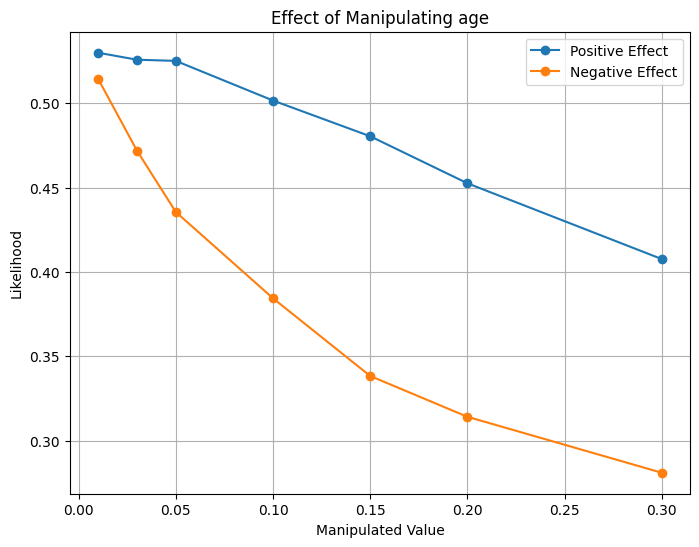

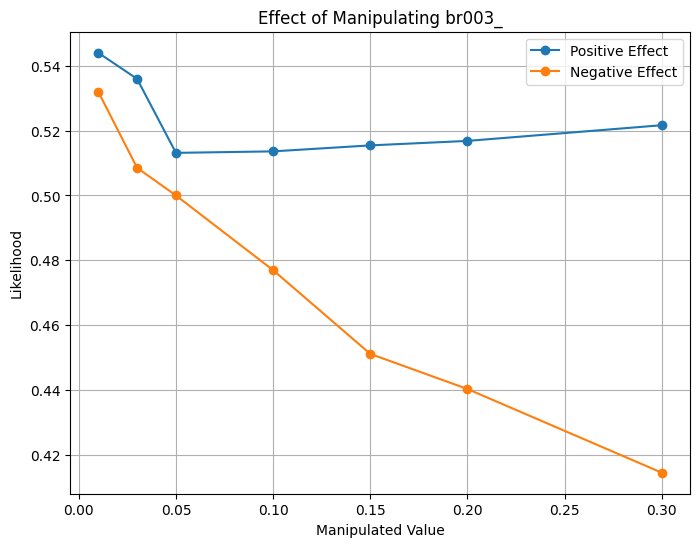

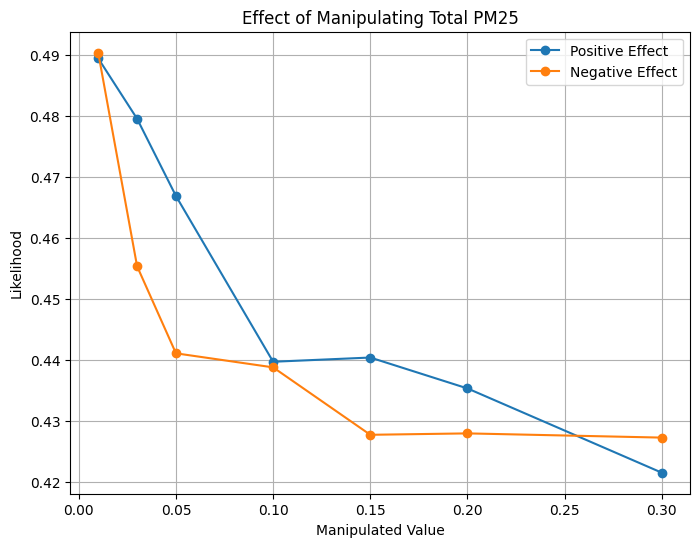

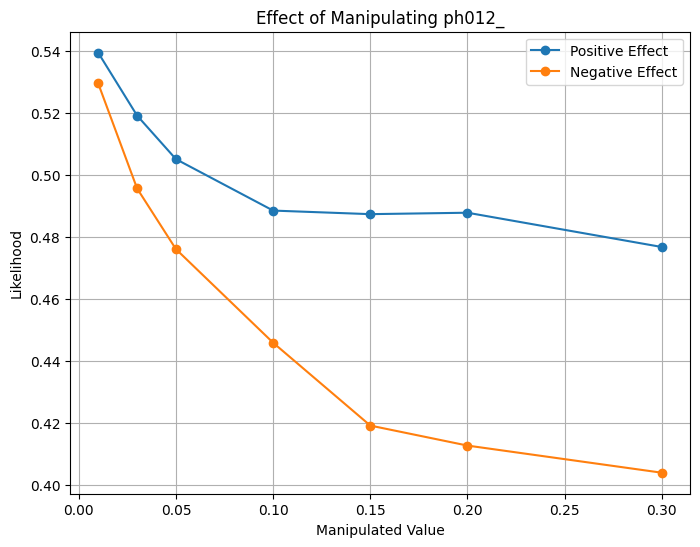

{'Accuracy': 0.759327498848457,
 'Precision': 0.7407729049066435,
 'Recall': 0.7920148560817084,
 'F1 Score': 0.7655373569665694}

In [ ]:
#DecisionTree without feature selection
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(dataframe, independent_var):

    rows_to_drop = dataframe[dataframe['ph006d4'] == 0].index
    rows_to_drop = random.sample(list(rows_to_drop), 36000)
    dataframe = dataframe.drop(rows_to_drop)

    X = dataframe.drop([independent_var, 'Total CM', 'Total PM25', 'Total NOx', 'Total SO', 'br002_', 'br001_', 'ph011d3',
                          'ph048d2', 'ph049d9', 'ph048d3', 'ph049d1', 'ph049d3', 'ph049d4', 'ph011d11',
                          'ph049d5', 'ph049d10', 'ph049d11', 'ph049d6', 'ph049d2', 'ph011d2', 'ph011d1', 'ph011d6',
                          'ph049d8', 'ph011d13', 'ph011d14', 'ph011d7', 'ph011d9', 'ph048d10', 'ph048d7', 'ph048d8',
                          'ph048d9', 'ph049d12', 'ph049d7'], axis=1)
    y = dataframe[independent_var]

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X_resampled)

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_resampled, test_size=0.2, random_state=42)

    model = DecisionTreeClassifier()

    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(confusion_matrix(y_test, y_pred))
    print('-' * 60)
    print(classification_report(y_test, y_pred))

    feature_importance = best_model.feature_importances_
    feature_dict = {}
    for col, importance in zip(X.columns, feature_importance):
        feature_dict[col] = importance

    sorted_feature_dict = {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1], reverse=True)}

    print(sorted_feature_dict)

    import matplotlib.pyplot as plt

    # feature manipulation for the given values
    X_test_df = pd.DataFrame(X_test, columns=X.columns)

    # empty lists to store the results
    positive_results = []
    negative_results = []

    for feature in ['age', 'br003_', 'Total PM10', 'ph012_']:
        print(f"Feature: {feature}")
        positive_likelihoods = []
        negative_likelihoods = []

        for value in [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                positive_likelihoods.append(likelihood)

        for value in [-0.01, -0.03, -0.05, -0.1, -0.15, -0.2, -0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                negative_likelihoods.append(likelihood)

        positive_results.append(positive_likelihoods)
        negative_results.append(negative_likelihoods)

    x_values = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]

    for i, feature in enumerate(['age', 'br003_', 'Total PM25', 'ph012_']):
        plt.figure(figsize=(8, 6))
        plt.plot(x_values, positive_results[i], marker='o', label='Positive Effect')
        plt.plot(x_values, negative_results[i], marker='o', label='Negative Effect')
        plt.xlabel('Manipulated Value')
        plt.ylabel('Likelihood')
        plt.title(f'Effect of Manipulating {feature}')
        plt.legend()
        plt.grid(True)
        plt.show()


    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

evaluate_model(s_stroke, 'ph006d4')


[[318 129]
 [151 312]]
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.71      0.69       447
           1       0.71      0.67      0.69       463

    accuracy                           0.69       910
   macro avg       0.69      0.69      0.69       910
weighted avg       0.69      0.69      0.69       910

{'ph048d4': 0.3863746386047688, 'ph006d2': 0.13547984761509377, 'age': 0.09919073891863447, 'ph048d1': 0.0801339599117673, 'hc012_': 0.07050269856561166, 'br015_': 0.0692115654060594, 'br003_': 0.04172951181299992, 'ph049d13': 0.04159980205985034, 'ph012_': 0.01654328906002632, 'ph048d6': 0.015126745375243082, 'ph011d4': 0.012621750674384409, 'gender': 0.011620528496139735, 'ph048d5': 0.011315015319104315, 'br016_': 0.006687223044460224, 'ph006d5': 0.001862685135856312, 'hc029_': 0.0, 'ph006d1': 0.0, 'ph006d3': 0.0, 'ph006d6': 0.0, 'ph011d10': 0.0, 'ph011d8': 0.0, 'Total PM10': 0.0}

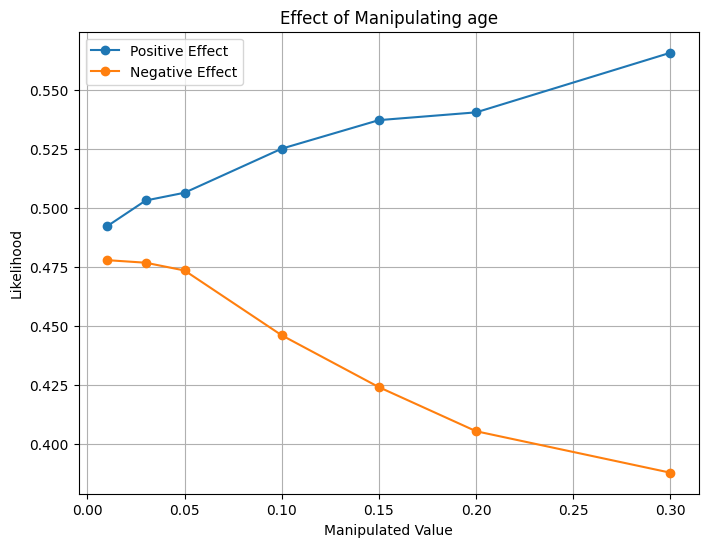

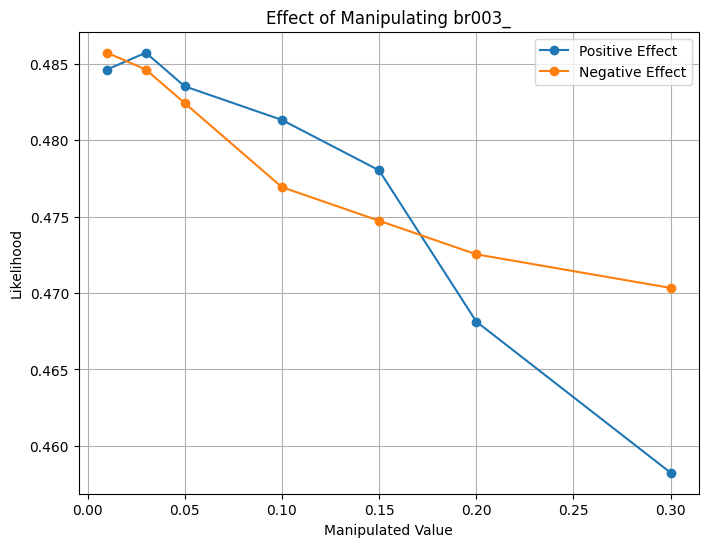

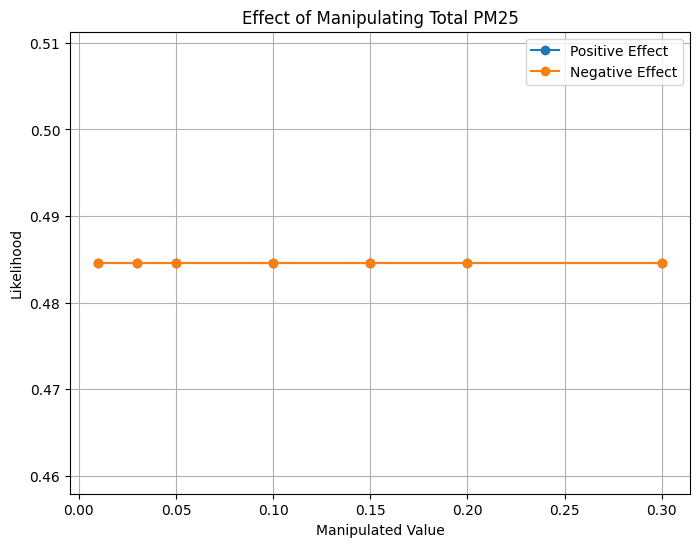

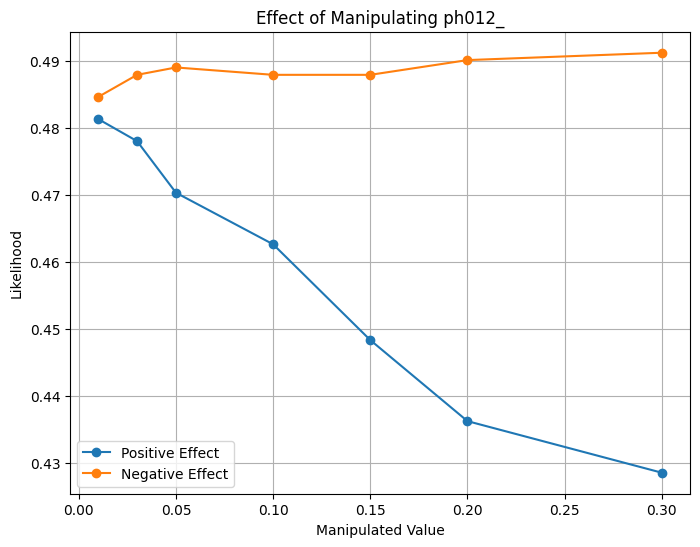

{'Accuracy': 0.6923076923076923,
 'Precision': 0.7074829931972789,
 'Recall': 0.673866090712743,
 'F1 Score': 0.6902654867256637}

In [ ]:
#DecisionTree without feature selection and smote
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(dataframe, independent_var):

    sick_df = dataframe[dataframe[independent_var] == 1]
    healthy_df = dataframe[dataframe[independent_var] == 0]

    # randomly select a subset of the "healthy" class to match the size of the "sick" class
    num_sick = len(sick_df)
    healthy_subset = healthy_df.sample(n=num_sick, random_state=42)

    # concatenate the "sick" and "healthy" subsets
    balanced_df = pd.concat([sick_df, healthy_subset])

    X = balanced_df.drop([independent_var, 'Total CM', 'Total PM25', 'Total NOx', 'Total SO', 'br002_', 'br001_', 'ph011d3',
                          'ph048d2', 'ph049d9', 'ph048d3', 'ph049d1', 'ph049d3', 'ph049d4', 'ph011d11',
                          'ph049d5', 'ph049d10', 'ph049d11', 'ph049d6', 'ph049d2', 'ph011d2', 'ph011d1', 'ph011d6',
                          'ph049d8', 'ph011d13', 'ph011d14', 'ph011d7', 'ph011d9', 'ph048d10', 'ph048d7', 'ph048d8',
                          'ph048d9', 'ph049d12', 'ph049d7'], axis=1)
    y = balanced_df[independent_var]

    # Min-Max normalization
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

    model = DecisionTreeClassifier()

    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(confusion_matrix(y_test, y_pred))
    print('-' * 60)
    print(classification_report(y_test, y_pred))

    feature_importance = best_model.feature_importances_
    feature_dict = {}
    for col, importance in zip(X.columns, feature_importance):
        feature_dict[col] = importance

    sorted_feature_dict = {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1], reverse=True)}

    print(sorted_feature_dict)

    import matplotlib.pyplot as plt
    # Perform feature manipulation for the given values
    X_test_df = pd.DataFrame(X_test, columns=X.columns)  # Convert X_test to DataFrame

    # empty lists to store the results
    positive_results = []
    negative_results = []

    for feature in ['age', 'br003_', 'Total PM10', 'ph012_']:
        print(f"Feature: {feature}")
        positive_likelihoods = []
        negative_likelihoods = []

        for value in [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                positive_likelihoods.append(likelihood)

        for value in [-0.01, -0.03, -0.05, -0.1, -0.15, -0.2, -0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                negative_likelihoods.append(likelihood)

        positive_results.append(positive_likelihoods)
        negative_results.append(negative_likelihoods)

    x_values = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]

    for i, feature in enumerate(['age', 'br003_', 'Total PM25', 'ph012_']):
        plt.figure(figsize=(8, 6))
        plt.plot(x_values, positive_results[i], marker='o', label='Positive Effect')
        plt.plot(x_values, negative_results[i], marker='o', label='Negative Effect')
        plt.xlabel('Manipulated Value')
        plt.ylabel('Likelihood')
        plt.title(f'Effect of Manipulating {feature}')
        plt.legend()
        plt.grid(True)
        plt.show()


    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

evaluate_model(s_stroke, 'ph006d4')


In [ ]:
#Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(dataframe, independent_var):

    X = dataframe.drop([independent_var, 'Total CM', 'Total PM25', 'Total NOx', 'Total SO', 'br002_', 'br001_', 'ph011d3',
                          'ph048d2', 'ph049d9', 'ph048d3', 'ph049d1', 'ph049d3', 'ph049d4', 'ph011d11',
                          'ph049d5', 'ph049d10', 'ph049d11', 'ph049d6', 'ph049d2', 'ph011d2', 'ph011d1', 'ph011d6',
                          'ph049d8', 'ph011d13', 'ph011d14', 'ph011d7', 'ph011d9', 'ph048d10', 'ph048d7', 'ph048d8',
                          'ph048d9', 'ph049d12', 'ph049d7'], axis=1)
    y = dataframe[independent_var]

    # apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    #  Min-Max normalization
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X_resampled)

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_resampled, test_size=0.2, random_state=42)

    best_f1 = 0
    best_k = None

    # loop through different values of k
    for k in range(1, X_train.shape[1] + 1):
        # feature selection using SelectKBest and mutual_info_classif
        selector = SelectKBest(score_func=mutual_info_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        model = RandomForestClassifier(random_state=42)

        param_grid = {
            'n_estimators': [64, 100, 128, 200],
            'max_features': [2, 3, 5, 7],
            'bootstrap': [True, False],
        }

        # grid search cross-validation to find the best hyperparameters
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')
        grid_search.fit(X_train_selected, y_train)

        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test_selected)

        f1 = f1_score(y_test, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_k = k

    print("Best k:", best_k)

    # perform feature selection using the best k value
    selector = SelectKBest(score_func=mutual_info_classif, k=best_k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    best_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)

    best_model.fit(X_train_selected, y_train)

    y_pred = best_model.predict(X_test_selected)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(confusion_matrix(y_test, y_pred))
    print('-' * 60)
    print(classification_report(y_test, y_pred))

    feature_importance = best_model.feature_importances_
    feature_dict = {}
    for col, importance in zip(X.columns, feature_importance):
        feature_dict[col] = importance

    sorted_feature_dict = {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1], reverse=True)}

    print(sorted_feature_dict)

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

evaluate_model(s_stroke, 'ph006d4')


Best k: 8
[[1896  256]
 [ 377 1813]]
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      2152
           1       0.88      0.83      0.85      2190

    accuracy                           0.85      4342
   macro avg       0.86      0.85      0.85      4342
weighted avg       0.86      0.85      0.85      4342

{'br015_': 0.44995332, 'br003_': 0.20965986, 'gender': 0.08186395, 'hc012_': 0.07305699, 'ph006d1': 0.070658214, 'age': 0.050409723, 'br016_': 0.04362518, 'hc029_': 0.020772757}
Feature: age
Feature: br003_
Feature: Total PM10
Feature: ph012_


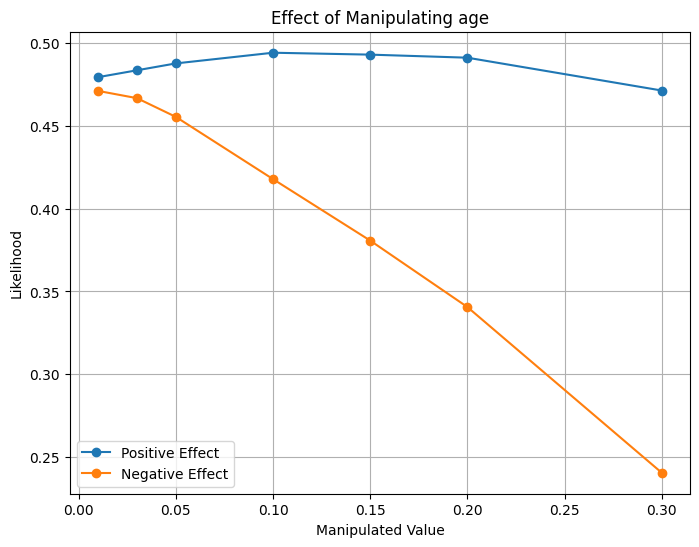

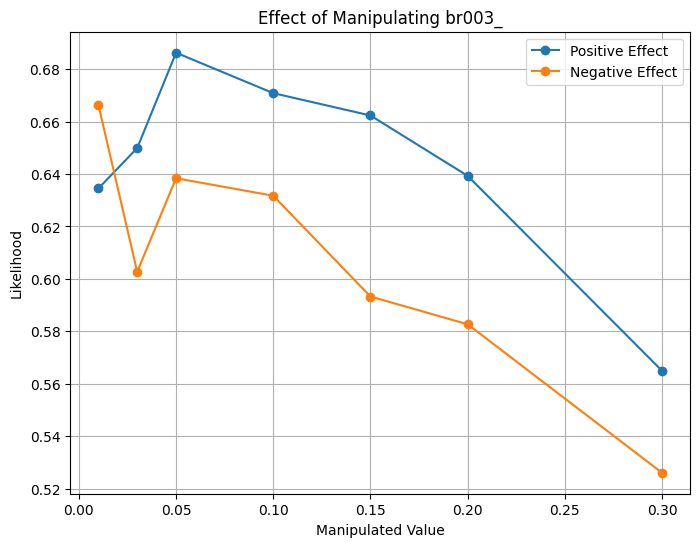

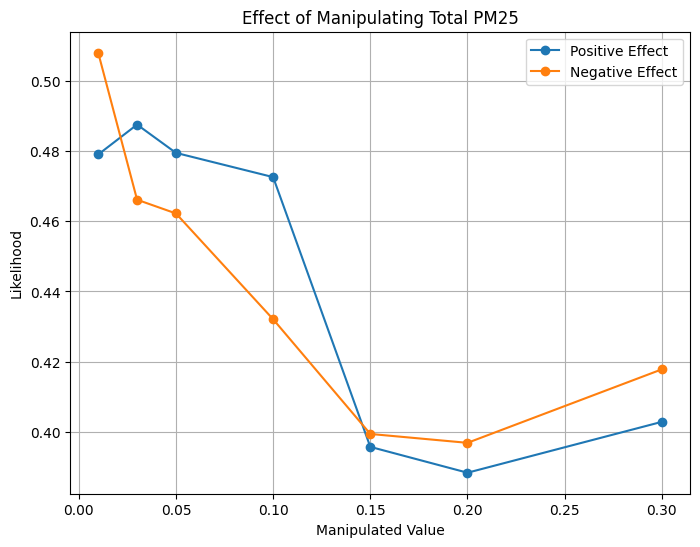

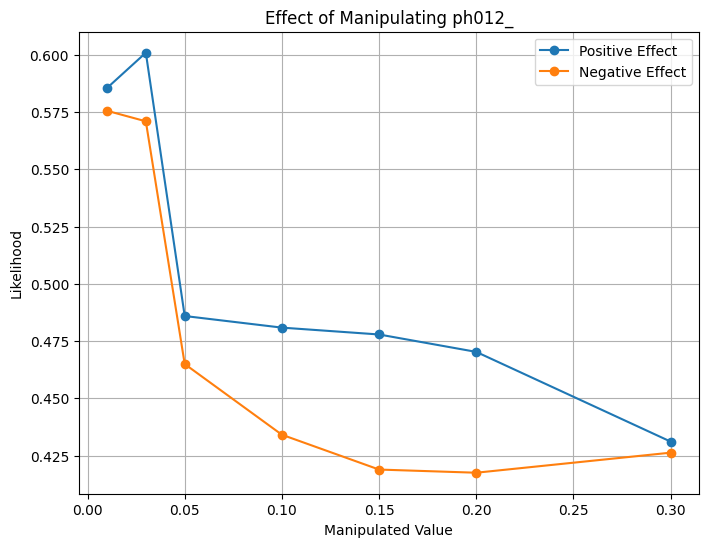

{'Accuracy': 0.8542146476278213,
 'Precision': 0.8762687288545191,
 'Recall': 0.8278538812785388,
 'F1 Score': 0.8513735618689834}

In [ ]:
#XGBoost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import random

def evaluate_model(dataframe, independent_var):

    rows_to_drop = dataframe[dataframe['ph006d4'] == 0].index
    rows_to_drop = random.sample(list(rows_to_drop), 36000)
    dataframe = dataframe.drop(rows_to_drop)


    X = dataframe.drop([independent_var, 'Total CM', 'Total PM25', 'Total NOx', 'Total SO', 'br002_', 'br001_', 'ph011d3',
                          'ph048d2', 'ph049d9', 'ph048d3', 'ph049d1', 'ph049d3', 'ph049d4', 'ph011d11',
                          'ph049d5', 'ph049d10', 'ph049d11', 'ph049d6', 'ph049d2', 'ph011d2', 'ph011d1', 'ph011d6',
                          'ph049d8', 'ph011d13', 'ph011d14', 'ph011d7', 'ph011d9', 'ph048d10', 'ph048d7', 'ph048d8',
                          'ph048d9', 'ph049d12', 'ph049d7'], axis=1)
    y = dataframe[independent_var]

    # apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Min-Max normalization
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X_resampled)

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_resampled, test_size=0.2, random_state=42)

    best_f1 = 0
    best_k = None

    # loop through different values of k
    for k in range(1, X_train.shape[1] + 1):
        # feature selection using SelectKBest and mutual_info_classif
        selector = SelectKBest(score_func=mutual_info_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        model = xgb.XGBClassifier(random_state=42)

        param_grid = {
            'n_estimators': [64, 100, 128, 200],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.1, 0.01, 0.001],
        }

        # grid search cross-validation to find the best hyperparameters
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')
        grid_search.fit(X_train_selected, y_train)

        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test_selected)

        f1 = f1_score(y_test, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_k = k

    print("Best k:", best_k)

    # perform feature selection using the best k value
    selector = SelectKBest(score_func=mutual_info_classif, k=best_k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    best_model = xgb.XGBClassifier(**grid_search.best_params_, random_state=42)

    best_model.fit(X_train_selected, y_train)

    y_pred = best_model.predict(X_test_selected)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(confusion_matrix(y_test, y_pred))
    print('-' * 60)
    print(classification_report(y_test, y_pred))

    feature_importance = best_model.feature_importances_
    feature_dict = {}
    for col, importance in zip(X.columns, feature_importance):
        feature_dict[col] = importance

    sorted_feature_dict = {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1], reverse=True)}

    print(sorted_feature_dict)


    import matplotlib.pyplot as plt

    # Get the selected feature columns based on the best_k value
    selected_features = selector.get_support(indices=True)
    selected_feature_names = X.columns[selected_features]

    # feature manipulation for the selected features
    X_test_df = pd.DataFrame(X_test_selected, columns=selected_feature_names)

    # empty lists to store the results
    positive_results = []
    negative_results = []

    for feature in ['age', 'br003_', 'Total PM10', 'ph012_']:
        print(f"Feature: {feature}")
        positive_likelihoods = []
        negative_likelihoods = []

        for value in [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                positive_likelihoods.append(likelihood)

        for value in [-0.01, -0.03, -0.05, -0.1, -0.15, -0.2, -0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                negative_likelihoods.append(likelihood)

        positive_results.append(positive_likelihoods)
        negative_results.append(negative_likelihoods)

    x_values = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]

    for i, feature in enumerate(['age', 'br003_', 'Total PM25', 'ph012_']):
        plt.figure(figsize=(8, 6))
        plt.plot(x_values, positive_results[i], marker='o', label='Positive Effect')
        plt.plot(x_values, negative_results[i], marker='o', label='Negative Effect')
        plt.xlabel('Manipulated Value')
        plt.ylabel('Likelihood')
        plt.title(f'Effect of Manipulating {feature}')
        plt.legend()
        plt.grid(True)
        plt.show()



    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

evaluate_model(s_stroke, 'ph006d4')


[[325 122]
 [140 323]]
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.73      0.71       447
           1       0.73      0.70      0.71       463

    accuracy                           0.71       910
   macro avg       0.71      0.71      0.71       910
weighted avg       0.71      0.71      0.71       910

{'ph048d4': 0.19004051, 'ph048d6': 0.16549075, 'ph048d1': 0.12562445, 'ph048d5': 0.10748042, 'hc012_': 0.05627492, 'ph006d2': 0.056133363, 'ph011d4': 0.03540373, 'ph049d13': 0.032459002, 'br015_': 0.03192636, 'gender': 0.02602432, 'age': 0.023269238, 'ph006d1': 0.02293466, 'br016_': 0.022235198, 'ph011d8': 0.01722488, 'Total PM10': 0.014730689, 'ph006d3': 0.013676069, 'ph006d5': 0.012783751, 'ph006d6': 0.012087944, 'br003_': 0.011702817, 'ph011d10': 0.011552561, 'ph012_': 0.010944435, 'hc029_': 0.0}
Feature: age
Feature: br003_
Feature: Total PM10
Feature: ph012_


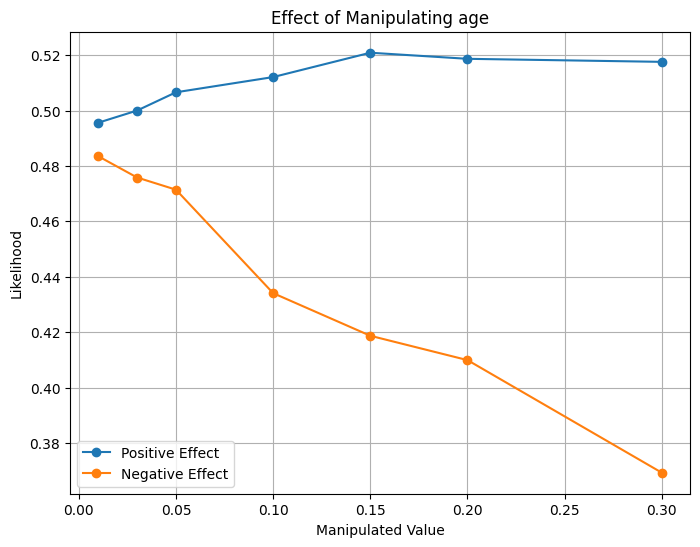

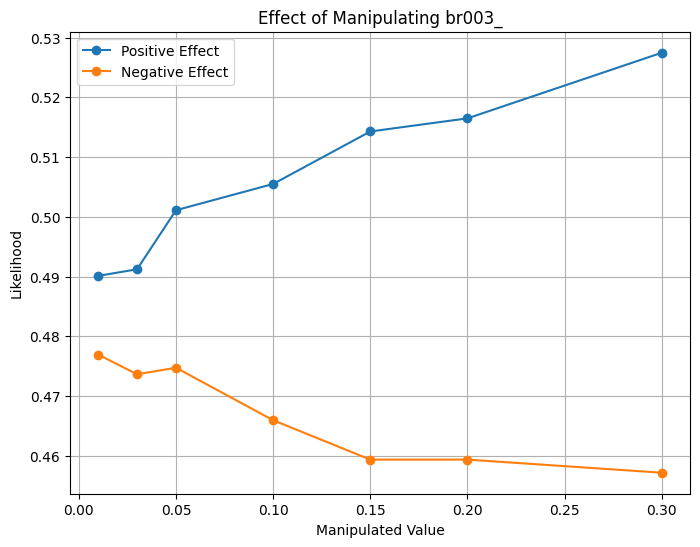

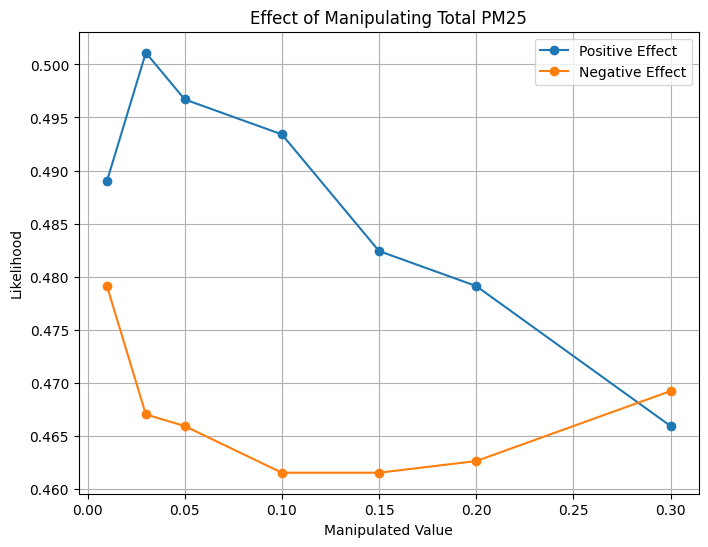

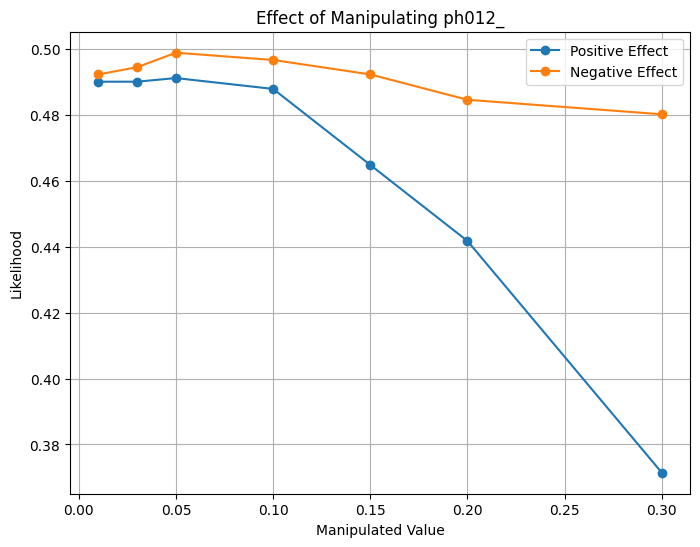

{'Accuracy': 0.7120879120879121,
 'Precision': 0.7258426966292135,
 'Recall': 0.6976241900647948,
 'F1 Score': 0.7114537444933922}

In [ ]:
#XGBoost no feature selection, no smote insted use equal balance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import random

def evaluate_model(dataframe, independent_var):

    sick_df = dataframe[dataframe[independent_var] == 1]
    healthy_df = dataframe[dataframe[independent_var] == 0]

    # randomly select a subset of the "healthy" class to match the size of the "sick" class
    num_sick = len(sick_df)
    healthy_subset = healthy_df.sample(n=num_sick, random_state=42)

    # concatenate the "sick" and "healthy" subsets
    balanced_df = pd.concat([sick_df, healthy_subset])

    X = balanced_df.drop([independent_var, 'Total CM', 'Total PM25', 'Total NOx', 'Total SO', 'br002_', 'br001_', 'ph011d3',
                          'ph048d2', 'ph049d9', 'ph048d3', 'ph049d1', 'ph049d3', 'ph049d4', 'ph011d11',
                          'ph049d5', 'ph049d10', 'ph049d11', 'ph049d6', 'ph049d2', 'ph011d2', 'ph011d1', 'ph011d6',
                          'ph049d8', 'ph011d13', 'ph011d14', 'ph011d7', 'ph011d9', 'ph048d10', 'ph048d7', 'ph048d8',
                          'ph048d9', 'ph049d12', 'ph049d7'], axis=1)
    y = balanced_df[independent_var]

    # Min-Max normalization
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)



    model = xgb.XGBClassifier(random_state=42)

    param_grid = {
        'n_estimators': [64, 100, 128, 200],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01, 0.001],
    }

    # grid search cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(confusion_matrix(y_test, y_pred))
    print('-' * 60)
    print(classification_report(y_test, y_pred))

    feature_importance = best_model.feature_importances_
    feature_dict = {}
    for col, importance in zip(X.columns, feature_importance):
        feature_dict[col] = importance

    sorted_feature_dict = {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1], reverse=True)}

    print(sorted_feature_dict)

    import matplotlib.pyplot as plt
    # feature manipulation for the given values
    X_test_df = pd.DataFrame(X_test, columns=X.columns)

    # empty lists to store the results
    positive_results = []
    negative_results = []

    for feature in ['age', 'br003_', 'Total PM10', 'ph012_']:
        print(f"Feature: {feature}")
        positive_likelihoods = []
        negative_likelihoods = []

        for value in [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                positive_likelihoods.append(likelihood)

        for value in [-0.01, -0.03, -0.05, -0.1, -0.15, -0.2, -0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                negative_likelihoods.append(likelihood)

        positive_results.append(positive_likelihoods)
        negative_results.append(negative_likelihoods)

    # Plotting the results
    x_values = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]

    for i, feature in enumerate(['age', 'br003_', 'Total PM25', 'ph012_']):
        plt.figure(figsize=(8, 6))
        plt.plot(x_values, positive_results[i], marker='o', label='Positive Effect')
        plt.plot(x_values, negative_results[i], marker='o', label='Negative Effect')
        plt.xlabel('Manipulated Value')
        plt.ylabel('Likelihood')
        plt.title(f'Effect of Manipulating {feature}')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

evaluate_model(s_stroke, 'ph006d4')


In [ ]:
#LightGBM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb

def evaluate_model(dataframe, independent_var):

    # randomaly choose 30000 people that didn't get stroke and drop them.
    rows_to_drop = dataframe[dataframe['ph006d4'] == 0].index
    rows_to_drop = random.sample(list(rows_to_drop), 30000)
    dataframe = dataframe.drop(rows_to_drop)

    X = dataframe.drop([independent_var, 'Total CM', 'Total PM25', 'Total NOx', 'Total SO', 'br002_', 'br001_', 'ph011d3',
                          'ph048d2', 'ph049d9', 'ph048d3', 'ph049d1', 'ph049d3', 'ph049d4', 'ph011d11',
                          'ph049d5', 'ph049d10', 'ph049d11', 'ph049d6', 'ph049d2', 'ph011d2', 'ph011d1', 'ph011d6',
                          'ph049d8', 'ph011d13', 'ph011d14', 'ph011d7', 'ph011d9', 'ph048d10', 'ph048d7', 'ph048d8',
                          'ph048d9', 'ph049d12', 'ph049d7'], axis=1)
    y = dataframe[independent_var]

    # apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Min-Max normalization
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X_resampled)

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_resampled, test_size=0.2, random_state=42)

    best_f1 = 0
    best_k = None

    # loop through different values of k
    for k in range(1, X_train.shape[1] + 1):
        # feature selection using SelectKBest and mutual_info_classif
        selector = SelectKBest(score_func=mutual_info_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        model = lgb.LGBMClassifier(random_state=42)

        param_grid = {
            'n_estimators': [64, 100, 128, 200],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.1, 0.01, 0.001],
        }

        # grid search cross-validation to find the best hyperparameters
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')
        grid_search.fit(X_train_selected, y_train)

        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test_selected)

        f1 = f1_score(y_test, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_k = k

    print("Best k:", best_k)

    # perform feature selection using the best k value
    selector = SelectKBest(score_func=mutual_info_classif, k=best_k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    best_model = lgb.LGBMClassifier(**grid_search.best_params_, random_state=42)

    best_model.fit(X_train_selected, y_train)

    y_pred = best_model.predict(X_test_selected)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(confusion_matrix(y_test, y_pred))
    print('-' * 60)
    print(classification_report(y_test, y_pred))

    feature_importance = best_model.feature_importances_
    feature_dict = {}
    for col, importance in zip(X.columns, feature_importance):
        feature_dict[col] = importance

    sorted_feature_dict = {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1], reverse=True)}

    print(sorted_feature_dict)

    import matplotlib.pyplot as plt

    # Get the selected feature columns based on the best_k value
    selected_features = selector.get_support(indices=True)
    selected_feature_names = X.columns[selected_features]

    # feature manipulation for the selected features
    X_test_df = pd.DataFrame(X_test_selected, columns=selected_feature_names)

    # Initialize empty lists to store the results
    positive_results = []
    negative_results = []

    for feature in ['age', 'br003_', 'Total PM10', 'ph012_']:
        print(f"Feature: {feature}")
        positive_likelihoods = []
        negative_likelihoods = []

        for value in [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                positive_likelihoods.append(likelihood)

        for value in [-0.01, -0.03, -0.05, -0.1, -0.15, -0.2, -0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                negative_likelihoods.append(likelihood)

        positive_results.append(positive_likelihoods)
        negative_results.append(negative_likelihoods)

    x_values = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]

    for i, feature in enumerate(['age', 'br003_', 'Total PM10', 'ph012_']):
        plt.figure(figsize=(8, 6))
        plt.plot(x_values, positive_results[i], marker='o', label='Positive Effect')
        plt.plot(x_values, negative_results[i], marker='o', label='Negative Effect')
        plt.xlabel('Manipulated Value')
        plt.ylabel('Likelihood')
        plt.title(f'Effect of Manipulating {feature}')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

evaluate_model(s_stroke, 'ph006d4')


[[3073  319]
 [ 417 2933]]
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      3392
           1       0.90      0.88      0.89      3350

    accuracy                           0.89      6742
   macro avg       0.89      0.89      0.89      6742
weighted avg       0.89      0.89      0.89      6742

{'Total PM10': 1062, 'ph012_': 984, 'br003_': 939, 'age': 607, 'br016_': 432, 'br015_': 286, 'ph006d2': 102, 'ph006d3': 92, 'hc012_': 81, 'ph048d6': 78, 'gender': 75, 'ph011d4': 57, 'ph048d4': 54, 'ph048d1': 52, 'ph006d5': 47, 'ph006d1': 44, 'ph006d6': 43, 'ph011d8': 42, 'ph049d13': 40, 'ph048d5': 35, 'ph011d10': 31, 'hc029_': 0}
Feature: age
Feature: br003_
Feature: Total PM10
Feature: ph012_


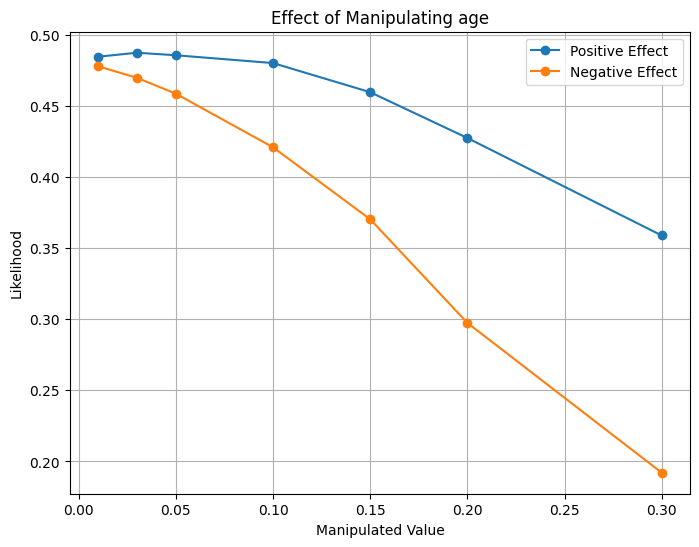

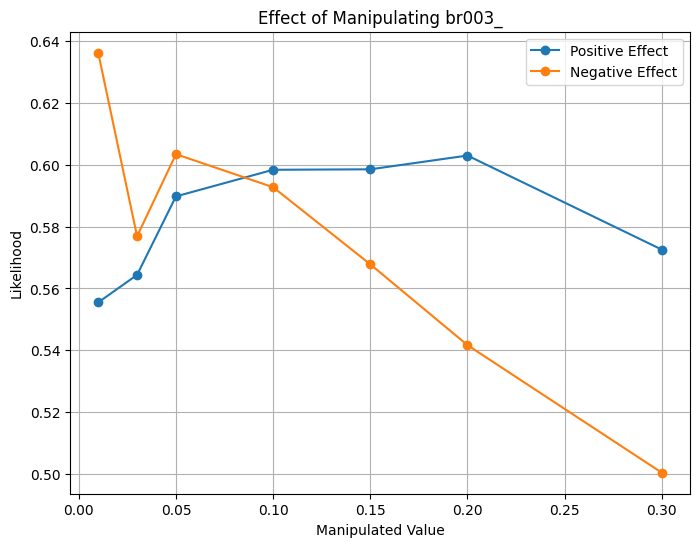

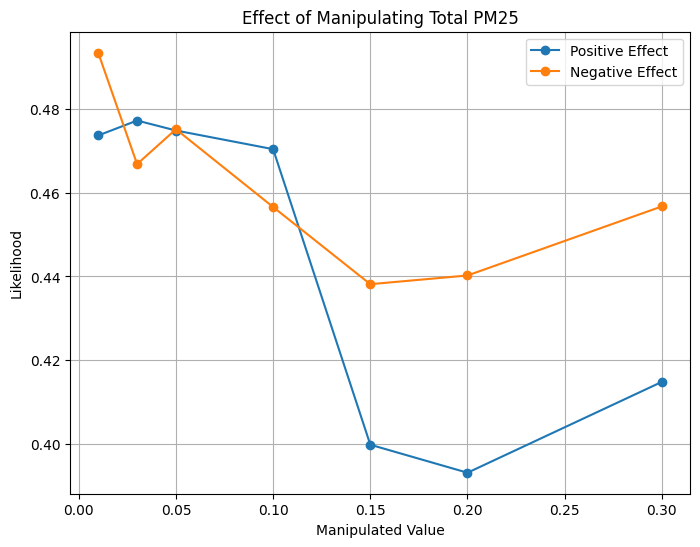

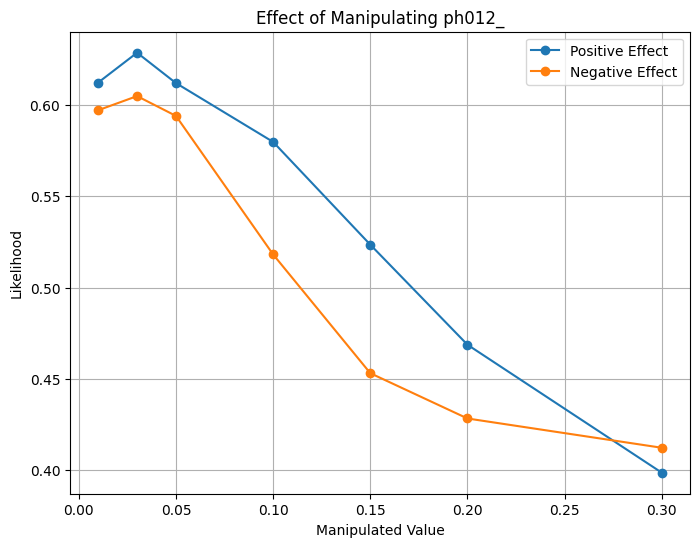

{'Accuracy': 0.8908335805398991,
 'Precision': 0.9019065190651907,
 'Recall': 0.8755223880597015,
 'F1 Score': 0.8885186307179643}

In [ ]:
#lightGBM no feature selection
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
import matplotlib.pyplot as plt

def evaluate_model(dataframe, independent_var):

    # randomaly choose 30000 people that didn't get stroke and drop them.
    rows_to_drop = dataframe[dataframe['ph006d4'] == 0].index
    rows_to_drop = random.sample(list(rows_to_drop), 30000)
    dataframe = dataframe.drop(rows_to_drop)

    X = dataframe.drop([independent_var, 'Total CM', 'Total PM25', 'Total NOx', 'Total SO', 'br002_', 'br001_', 'ph011d3',
                          'ph048d2', 'ph049d9', 'ph048d3', 'ph049d1', 'ph049d3', 'ph049d4', 'ph011d11',
                          'ph049d5', 'ph049d10', 'ph049d11', 'ph049d6', 'ph049d2', 'ph011d2', 'ph011d1', 'ph011d6',
                          'ph049d8', 'ph011d13', 'ph011d14', 'ph011d7', 'ph011d9', 'ph048d10', 'ph048d7', 'ph048d8',
                          'ph048d9', 'ph049d12', 'ph049d7'], axis=1)
    y = dataframe[independent_var]

    # apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Min-Max normalization
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X_resampled)

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_resampled, test_size=0.2, random_state=42)

    model = lgb.LGBMClassifier(random_state=42)

    param_grid = {
        'n_estimators': [64, 100, 128, 200],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01, 0.001],
    }

    # grid search cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(confusion_matrix(y_test, y_pred))
    print('-' * 60)
    print(classification_report(y_test, y_pred))

    feature_importance = best_model.feature_importances_
    feature_dict = {}
    for col, importance in zip(X.columns, feature_importance):
        feature_dict[col] = importance

    sorted_feature_dict = {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1], reverse=True)}

    print(sorted_feature_dict)

    # Get the selected feature columns
    selected_feature_names = X.columns

    # feature manipulation for the selected features
    X_test_df = pd.DataFrame(X_test, columns=selected_feature_names)

    # empty lists to store the results
    positive_results = []
    negative_results = []

    for feature in ['age', 'br003_', 'Total PM10', 'ph012_']:
        print(f"Feature: {feature}")
        positive_likelihoods = []
        negative_likelihoods = []

        for value in [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                positive_likelihoods.append(likelihood)

        for value in [-0.01, -0.03, -0.05, -0.1, -0.15, -0.2, -0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                negative_likelihoods.append(likelihood)

        positive_results.append(positive_likelihoods)
        negative_results.append(negative_likelihoods)

    x_values = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]

    for i, feature in enumerate(['age', 'br003_', 'Total PM25', 'ph012_']):
        plt.figure(figsize=(8, 6))
        plt.plot(x_values, positive_results[i], marker='o', label='Positive Effect')
        plt.plot(x_values, negative_results[i], marker='o', label='Negative Effect')
        plt.xlabel('Manipulated Value')
        plt.ylabel('Likelihood')
        plt.title(f'Effect of Manipulating {feature}')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

evaluate_model(s_stroke, 'ph006d4')


[[334 113]
 [144 319]]
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       447
           1       0.74      0.69      0.71       463

    accuracy                           0.72       910
   macro avg       0.72      0.72      0.72       910
weighted avg       0.72      0.72      0.72       910

{'age': 360, 'ph006d2': 259, 'ph049d13': 233, 'br003_': 214, 'br015_': 207, 'hc012_': 204, 'ph012_': 195, 'ph011d4': 173, 'Total PM10': 161, 'ph048d6': 110, 'ph006d1': 101, 'ph048d1': 92, 'ph048d5': 87, 'br016_': 83, 'gender': 82, 'ph006d3': 82, 'ph048d4': 56, 'ph006d6': 39, 'ph011d10': 34, 'ph011d8': 27, 'ph006d5': 12, 'hc029_': 0}
Feature: age
Feature: br003_
Feature: Total PM10
Feature: ph012_


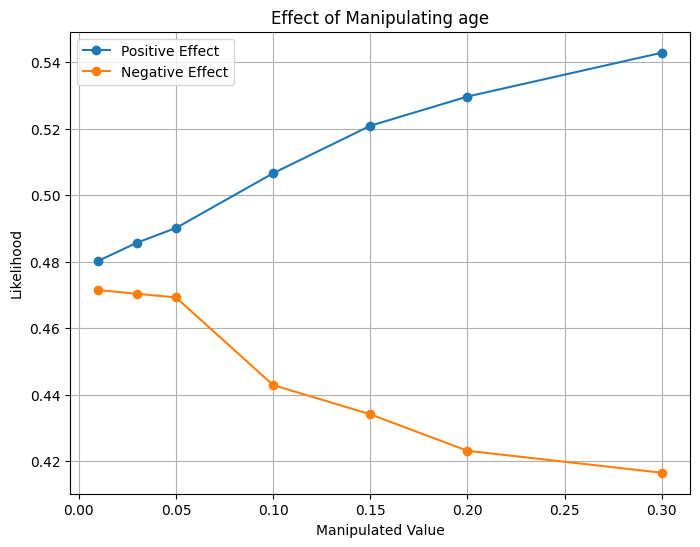

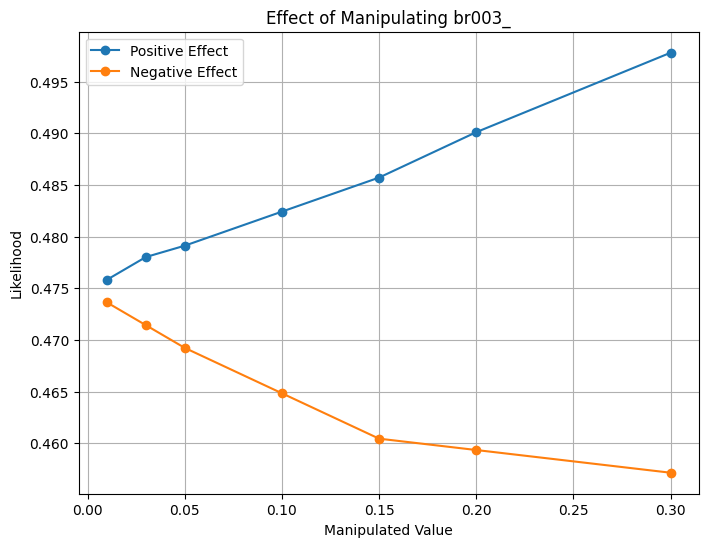

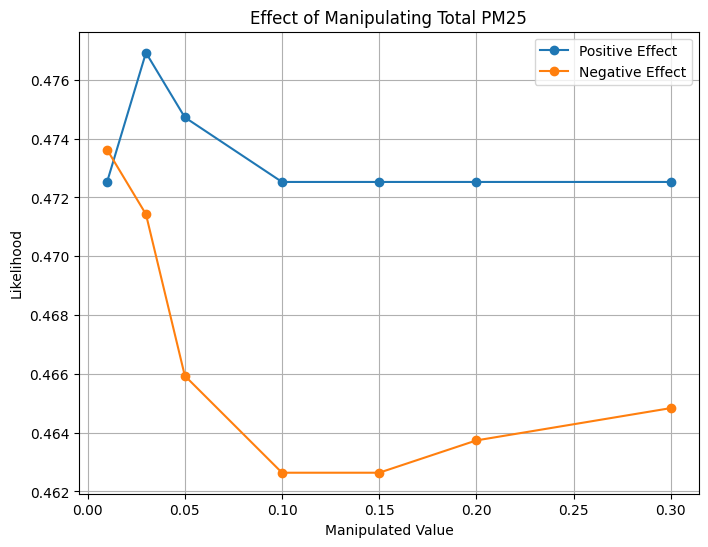

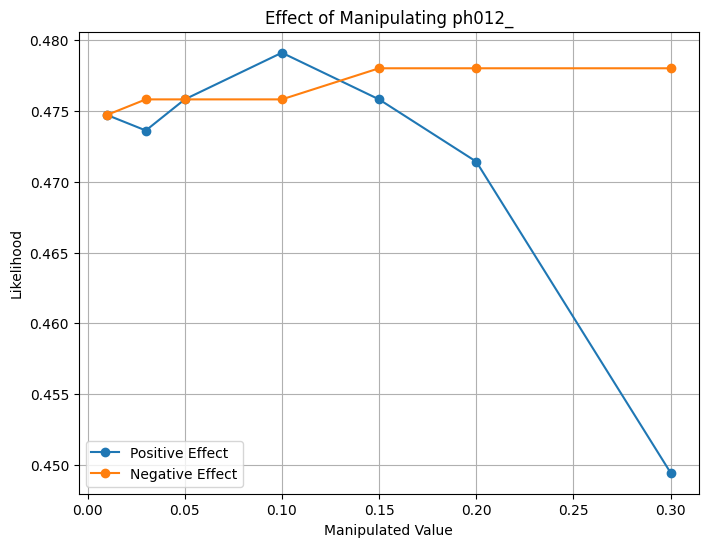

{'Accuracy': 0.7175824175824176,
 'Precision': 0.7384259259259259,
 'Recall': 0.6889848812095032,
 'F1 Score': 0.712849162011173}

In [ ]:
#lightGBM no feature selection, no smote insted equal balance
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
import matplotlib.pyplot as plt

def evaluate_model(dataframe, independent_var):

    sick_df = dataframe[dataframe[independent_var] == 1]
    healthy_df = dataframe[dataframe[independent_var] == 0]

    # randomly select a subset of the "healthy" class to match the size of the "sick" class
    num_sick = len(sick_df)
    healthy_subset = healthy_df.sample(n=num_sick, random_state=42)

    # concatenate the "sick" and "healthy" subsets
    balanced_df = pd.concat([sick_df, healthy_subset])

    X = balanced_df.drop([independent_var, 'Total CM', 'Total PM25', 'Total NOx', 'Total SO', 'br002_', 'br001_', 'ph011d3',
                          'ph048d2', 'ph049d9', 'ph048d3', 'ph049d1', 'ph049d3', 'ph049d4', 'ph011d11',
                          'ph049d5', 'ph049d10', 'ph049d11', 'ph049d6', 'ph049d2', 'ph011d2', 'ph011d1', 'ph011d6',
                          'ph049d8', 'ph011d13', 'ph011d14', 'ph011d7', 'ph011d9', 'ph048d10', 'ph048d7', 'ph048d8',
                          'ph048d9', 'ph049d12', 'ph049d7'], axis=1)
    y = balanced_df[independent_var]

    # Min-Max normalization
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

    model = lgb.LGBMClassifier(random_state=42)

    param_grid = {
        'n_estimators': [64, 100, 128, 200],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01, 0.001],
    }

    # grid search cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(confusion_matrix(y_test, y_pred))
    print('-' * 60)
    print(classification_report(y_test, y_pred))

    feature_importance = best_model.feature_importances_
    feature_dict = {}
    for col, importance in zip(X.columns, feature_importance):
        feature_dict[col] = importance

    sorted_feature_dict = {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1], reverse=True)}

    print(sorted_feature_dict)

    # Get the selected feature columns
    selected_feature_names = X.columns

    # feature manipulation for the selected features
    X_test_df = pd.DataFrame(X_test, columns=selected_feature_names)

    # empty lists to store the results
    positive_results = []
    negative_results = []

    for feature in ['age', 'br003_', 'Total PM10', 'ph012_']:
        print(f"Feature: {feature}")
        positive_likelihoods = []
        negative_likelihoods = []

        for value in [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                positive_likelihoods.append(likelihood)

        for value in [-0.01, -0.03, -0.05, -0.1, -0.15, -0.2, -0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                negative_likelihoods.append(likelihood)

        positive_results.append(positive_likelihoods)
        negative_results.append(negative_likelihoods)

    x_values = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]

    for i, feature in enumerate(['age', 'br003_', 'Total PM25', 'ph012_']):
        plt.figure(figsize=(8, 6))
        plt.plot(x_values, positive_results[i], marker='o', label='Positive Effect')
        plt.plot(x_values, negative_results[i], marker='o', label='Negative Effect')
        plt.xlabel('Manipulated Value')
        plt.ylabel('Likelihood')
        plt.title(f'Effect of Manipulating {feature}')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

evaluate_model(s_stroke, 'ph006d4')


/////////////////////////////////////////
/////////////////////////////////////////
/////////////////////////////////////////

       age  gender  br003_  br015_  br016_  hc012_  hc029_  ph006d1  ph006d2  \
0       72       0    50.0       3       3       0       0        1        1   
1       59       0    20.0       2       3       0       0        0        1   
2       60       1    35.0       1       3       0       0        0        1   
3       60       1    35.0       2       3       0       0        0        0   
4       58       0    30.0       2       2       1       0        0        0   
...    ...     ...     ...     ...     ...     ...     ...      ...      ...   
49109   78       1    30.0       0       3       1       0        0        0   
49110   81       0     3.0       0       2       1       0        1        1   
49115   64       0     2.0       2       3       0       0        0        0   
49118   67       1    15.0       0       3       0       0        0        0   
49124   67       1    46.0       0       3       0       0        1        0   

       ph006d3  ph006d5  ph006d6  ph011

Permutation explainer: 4343it [37:25,  1.93it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


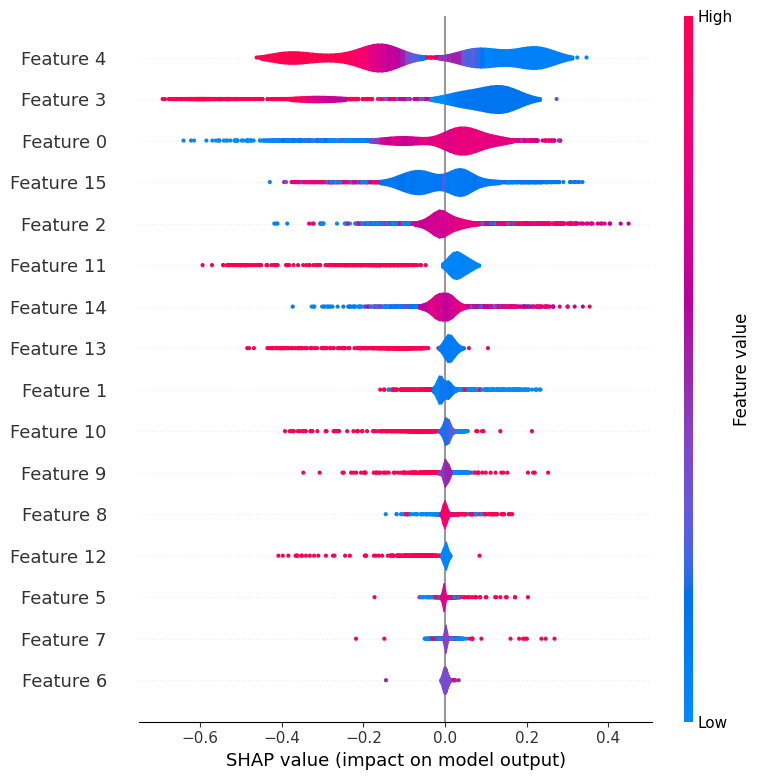

Feature: age
Feature: br003_
Feature: Total PM10


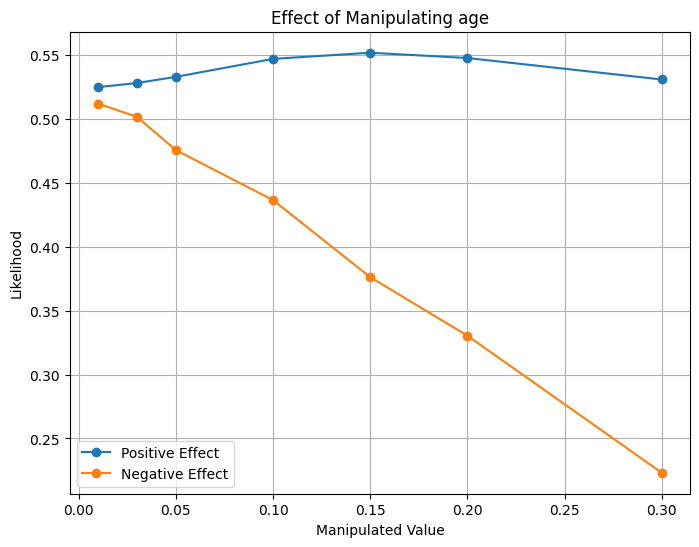

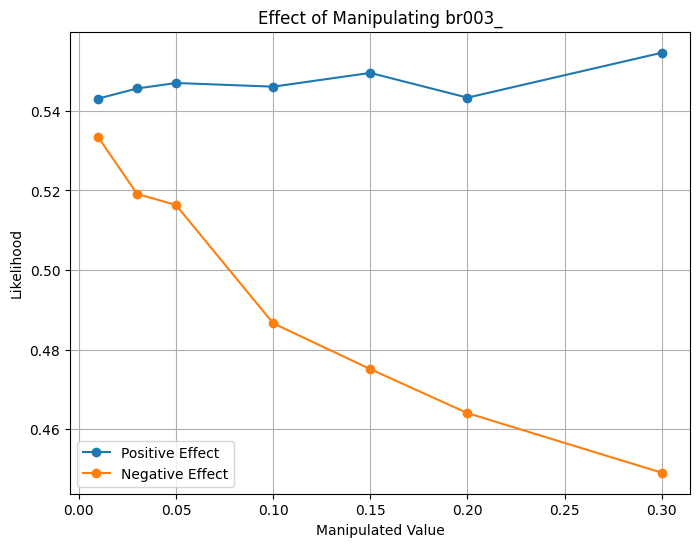

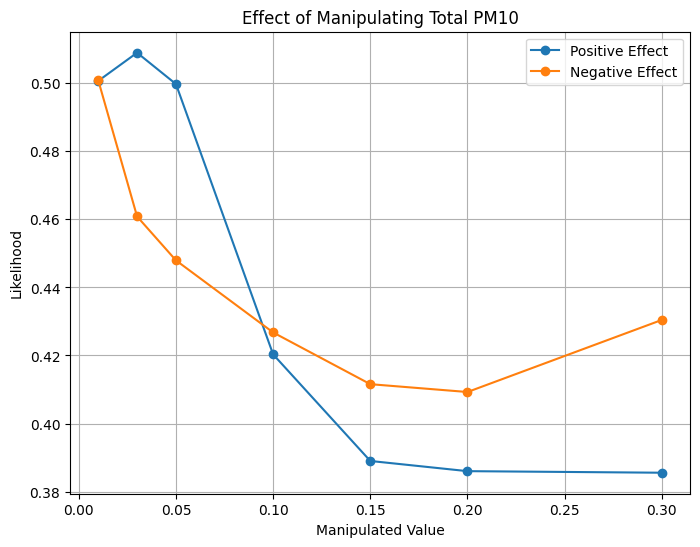

{'Accuracy': 0.7759097190234915,
 'Precision': 0.7626819585355095,
 'Recall': 0.7989833641404805,
 'F1 Score': 0.7804107424960506}

In [ ]:
#trying, maybe this is the best? 28/06
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import pandas as pd
import random
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(dataframe, independent_var):

    # randomaly choose 30000 people that didn't get stroke and drop them.
    rows_to_drop = dataframe[dataframe['ph006d4'] == 0].index
    rows_to_drop = random.sample(list(rows_to_drop), 36000)
    dataframe = dataframe.drop(rows_to_drop)


    # X = dataframe.drop([independent_var, 'Total CM', 'Total PM25', 'Total NOx', 'Total SO', 'br002_', 'br001_', 'ph011d3',
    #                       'ph048d2', 'ph049d9', 'ph048d3', 'ph049d1', 'ph049d3', 'ph049d4', 'ph011d11',
    #                       'ph049d5', 'ph049d10', 'ph049d11', 'ph049d6', 'ph049d2', 'ph011d2', 'ph011d1', 'ph011d6',
    #                       'ph049d8', 'ph011d13', 'ph011d14', 'ph011d7', 'ph011d9', 'ph048d10', 'ph048d7', 'ph048d8',
    #                       'ph048d9', 'ph049d12', 'ph049d7'], axis=1)
    X = dataframe.drop([independent_var, 'Total CM', 'Total PM25', 'Total NOx', 'Total SO', 'br002_', 'br001_', 'ph011d3',
                      'ph048d2', 'ph049d9', 'ph048d3', 'ph049d1', 'ph049d3', 'ph049d4', 'ph011d11',
                      'ph049d5', 'ph049d10', 'ph049d11', 'ph049d6', 'ph049d2', 'ph011d2', 'ph011d1', 'ph011d6',
                      'ph049d8', 'ph011d13', 'ph011d14', 'ph011d7', 'ph011d9', 'ph048d10', 'ph048d7', 'ph048d8',
                      'ph048d9', 'ph049d12', 'ph049d7','ph011d4', 'ph048d4', 'ph048d5', 'ph048d6', 'ph049d13','ph048d1'], axis=1)
    y = dataframe[independent_var]

    print(X)

    # apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    print(X_resampled)

    # Min-Max normalization
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X_resampled)

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_resampled, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42, max_depth=10)

    # parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [64, 100, 128, 200],
        'max_features': [2, 3, 5, 7],
        'bootstrap': [True, False],
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Check for overfitting
    train_predictions = best_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_f1 = f1_score(y_train, train_predictions)

    test_predictions = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_f1 = f1_score(y_test, test_predictions)

    print("Train Accuracy:", train_accuracy)
    print("Train F1 Score:", train_f1)
    print("Test Accuracy:", test_accuracy)
    print("Test F1 Score:", test_f1)

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(confusion_matrix(y_test, y_pred))
    print('-' * 60)
    print(classification_report(y_test, y_pred))

    # get feature importances
    feature_importances = best_model.feature_importances_
    coef_dict = {}
    for i in range(len(X.columns)):
        coef_dict[X.columns[i]] = feature_importances[i]

    # sort the feature importances in descending order
    sorted_coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: abs(item[1]), reverse=True)}

    print(sorted_coef_dict)

    import shap
    # Fits the explainer
    explainer = shap.Explainer(best_model.predict, X_test)
    # Calculates the SHAP values
    shap_values = explainer(X_test)

    # Plotting SHAP summary plot
    shap.summary_plot(shap_values, plot_type='violin')


    import matplotlib.pyplot as plt

    # feature manipulation for the given values
    X_test_df = pd.DataFrame(X_test, columns=X.columns)  # Convert X_test to DataFrame

    # empty lists to store the results
    positive_results = []
    negative_results = []

    for feature in ['age', 'br003_', 'Total PM10']:
        print(f"Feature: {feature}")
        positive_likelihoods = []
        negative_likelihoods = []

        for value in [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                positive_likelihoods.append(likelihood)

        for value in [-0.01, -0.03, -0.05, -0.1, -0.15, -0.2, -0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                negative_likelihoods.append(likelihood)

        positive_results.append(positive_likelihoods)
        negative_results.append(negative_likelihoods)

    x_values = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]

    for i, feature in enumerate(['age', 'br003_', 'Total PM10']):
        plt.figure(figsize=(8, 6))
        plt.plot(x_values, positive_results[i], marker='o', label='Positive Effect')
        plt.plot(x_values, negative_results[i], marker='o', label='Negative Effect')
        plt.xlabel('Manipulated Value')
        plt.ylabel('Likelihood')
        plt.title(f'Effect of Manipulating {feature}')
        plt.legend()
        plt.grid(True)
        plt.show()


    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

evaluate_model(s_stroke, 'ph006d4')


           age  gender    br003_    br015_    br016_  hc012_  hc029_  ph006d1  \
0     0.606061     0.0  0.505051  1.000000  1.000000     0.0     0.0      1.0   
1     0.424242     0.0  0.404040  0.000000  1.000000     0.0     0.0      0.0   
2     0.439394     1.0  0.454545  1.000000  1.000000     0.0     0.0      0.0   
3     0.469697     1.0  0.333333  1.000000  1.000000     1.0     0.0      0.0   
4     0.393939     1.0  0.151515  0.333333  0.333333     1.0     0.0      0.0   
...        ...     ...       ...       ...       ...     ...     ...      ...   
4543  0.666667     1.0  0.191919  0.000000  1.000000     0.0     0.0      0.0   
4544  0.484848     1.0  0.222222  1.000000  1.000000     0.0     0.0      1.0   
4545  0.636364     0.0  0.266527  1.000000  1.000000     1.0     0.0      0.0   
4546  0.545455     0.0  0.505051  0.000000  1.000000     1.0     0.0      0.0   
4547  0.696970     1.0  0.101010  0.000000  1.000000     1.0     0.0      0.0   

      ph006d2  ph006d3  ph0

Permutation explainer: 911it [08:41,  1.71it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


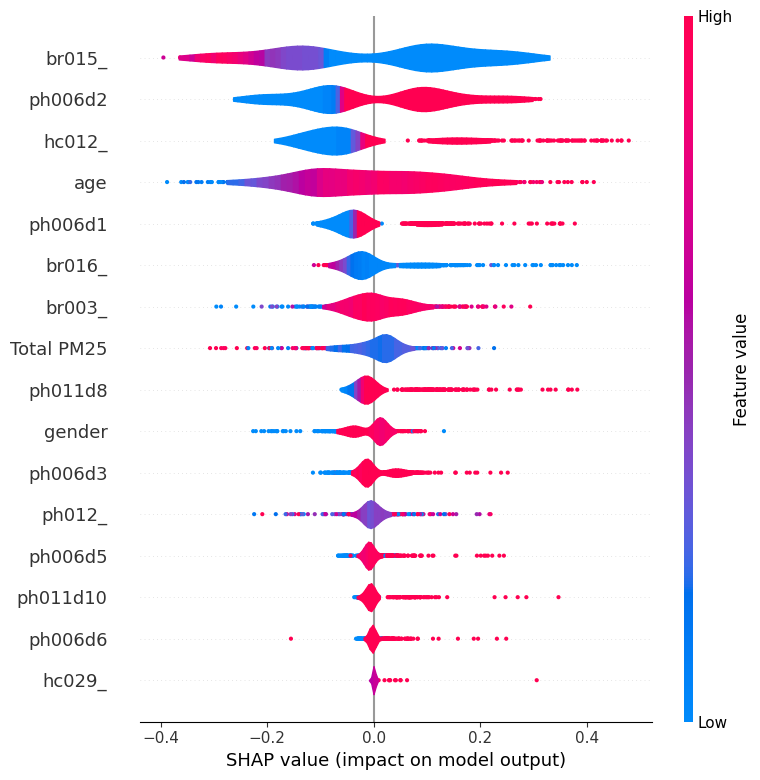

Feature: age


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

Feature: br003_


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

Feature: Total PM25


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

Feature: ph012_


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


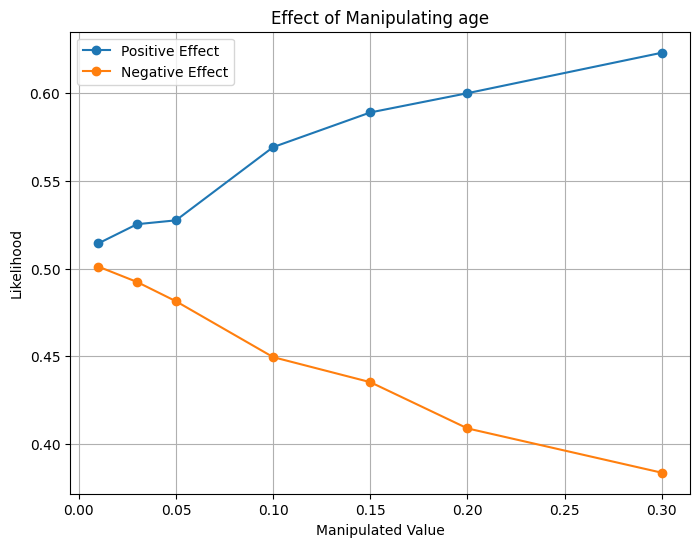

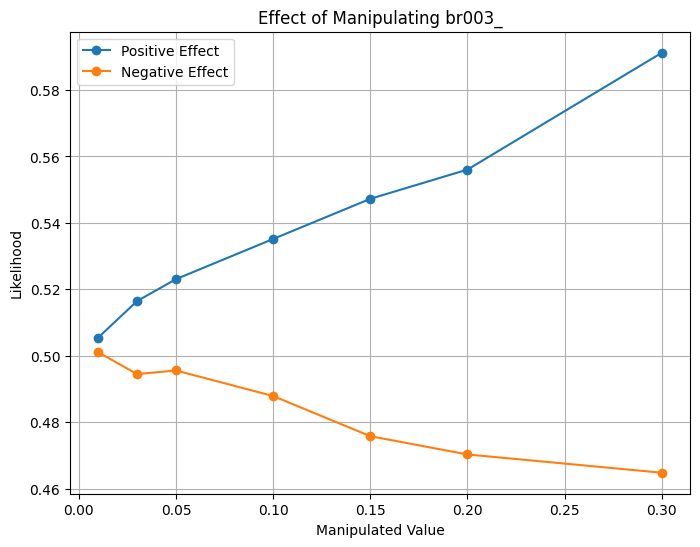

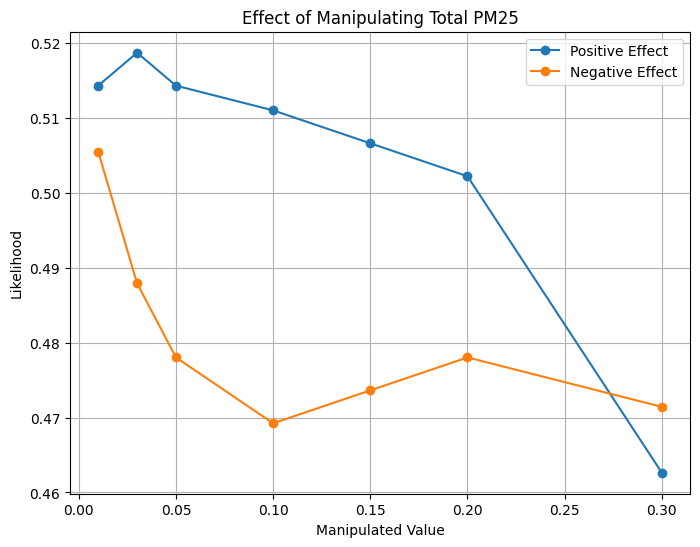

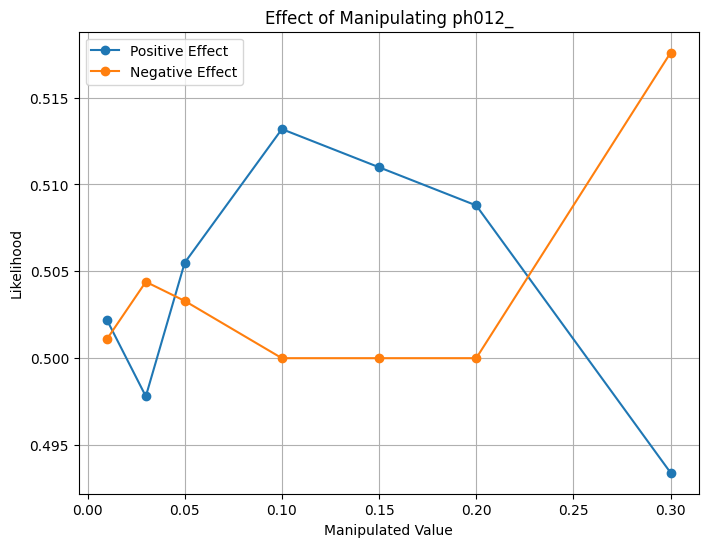

{'Accuracy': 0.7,
 'Precision': 0.7074235807860262,
 'Recall': 0.6997840172786177,
 'F1 Score': 0.7035830618892508}

In [ ]:
#best! last
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import pandas as pd
from imblearn.over_sampling import SMOTE


def evaluate_model(dataframe, independent_var):

    # separate the "sick" and "healthy" classes
    sick_df = dataframe[dataframe[independent_var] == 1]
    healthy_df = dataframe[dataframe[independent_var] == 0]

    # randomly select a subset of the "healthy" class to match the size of the "sick" class
    num_sick = len(sick_df)
    healthy_subset = healthy_df.sample(n=num_sick, random_state=42)

    # concatenate the "sick" and "healthy" subsets
    balanced_df = pd.concat([sick_df, healthy_subset])


    # X = balanced_df.drop([independent_var, 'Total CM', 'Total NOx', 'Total PM10', 'Total SO', 'br002_', 'br001_', 'ph011d3',
    #                   'ph048d2', 'ph049d9', 'ph048d3', 'ph049d1', 'ph049d3', 'ph049d4', 'ph011d11', 'ph011d10',
    #                   'ph049d5', 'ph049d10', 'ph049d11', 'ph049d6', 'ph049d2', 'ph011d2', 'ph011d1', 'ph011d6',
    #                   'ph049d8','ph011d13', 'ph011d14', 'ph011d7', 'ph011d9', 'ph048d10', 'ph048d7', 'ph048d8', 'ph048d9', 'ph049d12', 'ph049d7'], axis=1)

    X = balanced_df.drop([independent_var, 'Total CM', 'Total PM10', 'Total NOx', 'Total SO', 'br002_', 'br001_', 'ph011d3',
                  'ph048d2', 'ph049d9', 'ph048d3', 'ph049d1', 'ph049d3', 'ph049d4', 'ph011d11',
                  'ph049d5', 'ph049d10', 'ph049d11', 'ph049d6', 'ph049d2', 'ph011d2', 'ph011d1', 'ph011d6',
                  'ph049d8', 'ph011d13', 'ph011d14', 'ph011d7', 'ph011d9', 'ph048d10', 'ph048d7', 'ph048d8',
                  'ph048d9', 'ph049d12', 'ph049d7','ph011d4', 'ph048d4', 'ph048d5', 'ph048d6', 'ph049d13','ph048d1'], axis=1)

    y = balanced_df[independent_var]

    # Min-Max normalization
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    X = pd.DataFrame(X_normalized, columns=X.columns)

    print(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # perform oversampling of the minority class
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)

    model = RandomForestClassifier(random_state=42, max_depth=10)

    # define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [64, 100, 128, 200],
        'max_features': [2, 3, 5, 7],
        'bootstrap': [True, False],
    }


    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')

    grid_search.fit(X_train, y_train)


    best_model = grid_search.best_estimator_

    # Check for overfitting
    train_predictions = best_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_f1 = f1_score(y_train, train_predictions)

    test_predictions = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_f1 = f1_score(y_test, test_predictions)

    print("Train Accuracy:", train_accuracy)
    print("Train F1 Score:", train_f1)
    print("Test Accuracy:", test_accuracy)
    print("Test F1 Score:", test_f1)

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    from sklearn.metrics import classification_report, confusion_matrix
    print(confusion_matrix(y_test, y_pred))
    print('-' * 60)
    print(classification_report(y_test, y_pred))

    # get feature importances
    feature_importances = best_model.feature_importances_
    coef_dict = {}
    for i in range(len(X.columns)):
        coef_dict[X.columns[i]] = feature_importances[i]

    # sort the feature importances in descending order
    sorted_coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: abs(item[1]), reverse=True)}


    print(sorted_coef_dict)

    import shap
    # Fits the explainer
    explainer = shap.Explainer(best_model.predict, X_test)
    # Calculates the SHAP values
    shap_values = explainer(X_test)

    # Plotting SHAP summary plot
    shap.summary_plot(shap_values, plot_type='violin')

    import matplotlib.pyplot as plt

    #  feature manipulation for the given values
    X_test_df = pd.DataFrame(X_test, columns=X.columns)  # Convert X_test to DataFrame

    # empty lists to store the results
    positive_results = []
    negative_results = []

    for feature in ['age', 'br003_', 'Total PM25','ph012_']:
        print(f"Feature: {feature}")
        positive_likelihoods = []
        negative_likelihoods = []

        for value in [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                positive_likelihoods.append(likelihood)

        for value in [-0.01, -0.03, -0.05, -0.1, -0.15, -0.2, -0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                negative_likelihoods.append(likelihood)

        positive_results.append(positive_likelihoods)
        negative_results.append(negative_likelihoods)

    x_values = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]

    for i, feature in enumerate(['age', 'br003_', 'Total PM25', 'ph012_']):
        plt.figure(figsize=(8, 6))
        plt.plot(x_values, positive_results[i], marker='o', label='Positive Effect')
        plt.plot(x_values, negative_results[i], marker='o', label='Negative Effect')
        plt.xlabel('Manipulated Value')
        plt.ylabel('Likelihood')
        plt.title(f'Effect of Manipulating {feature}')
        plt.legend()
        plt.grid(True)
        plt.show()


    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

evaluate_model(s_stroke, 'ph006d4')


       age  gender  br003_  br015_  br016_  hc012_  hc029_  ph006d1  ph006d2  \
0       72       0    50.0       3       3       0       0        1        1   
1       59       0    20.0       2       3       0       0        0        1   
2       60       1    35.0       1       3       0       0        0        1   
3       60       1    35.0       2       3       0       0        0        0   
4       58       0    30.0       2       2       1       0        0        0   
...    ...     ...     ...     ...     ...     ...     ...      ...      ...   
49123   68       1    30.0       2       2       0       0        0        0   
49124   67       1    46.0       0       3       0       0        1        0   
49125   63       0    10.0       3       3       0       0        0        0   
49126   78       1    25.0       0       0       1       0        0        0   
49127   71       1     5.0       1       2       1       0        0        0   

       ph006d3  ph006d5  ph006d6  ph011

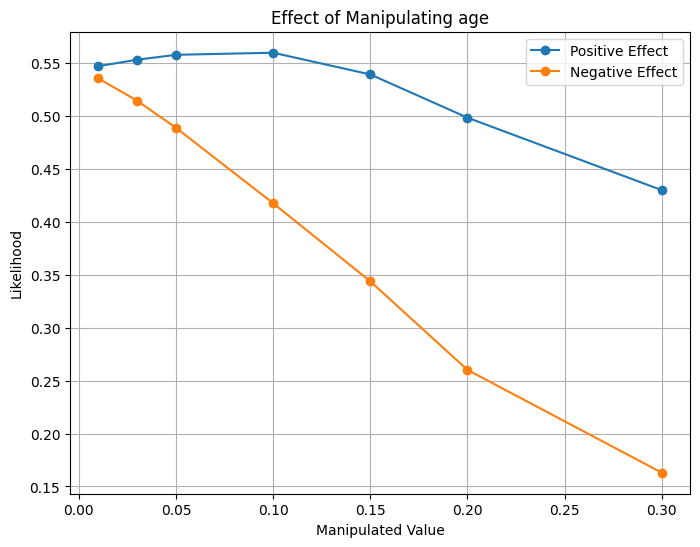

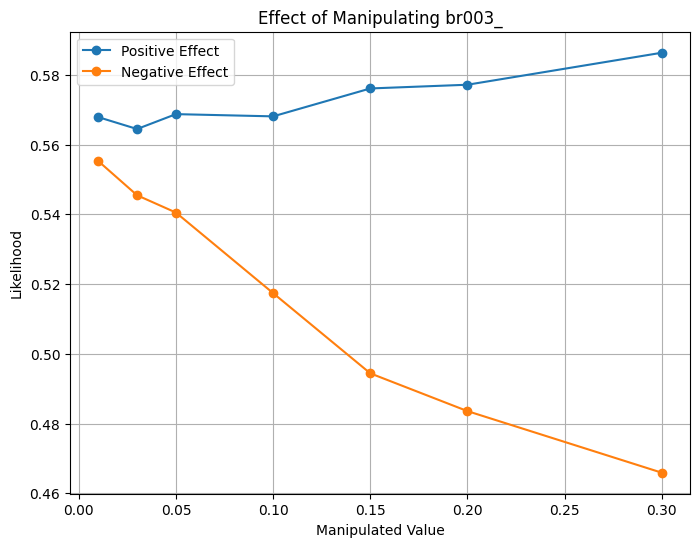

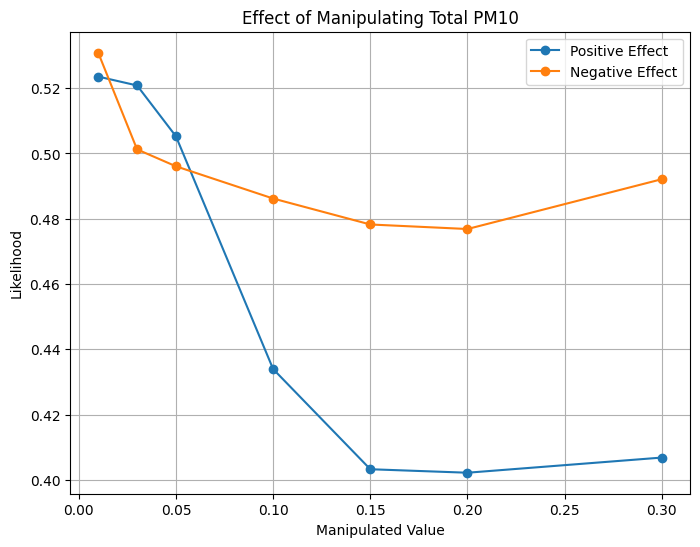

{'Accuracy': 0.8059972254828727,
 'Precision': 0.7774953563398181,
 'Recall': 0.853967572210888,
 'F1 Score': 0.813939207859994}

In [ ]:
#test random forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(dataframe, independent_var):


    X = dataframe.drop([independent_var, 'Total CM', 'Total PM25', 'Total NOx', 'Total SO', 'br002_', 'br001_', 'ph011d3',
                      'ph048d2', 'ph049d9', 'ph048d3', 'ph049d1', 'ph049d3', 'ph049d4', 'ph011d11',
                      'ph049d5', 'ph049d10', 'ph049d11', 'ph049d6', 'ph049d2', 'ph011d2', 'ph011d1', 'ph011d6',
                      'ph049d8', 'ph011d13', 'ph011d14', 'ph011d7', 'ph011d9', 'ph048d10', 'ph048d7', 'ph048d8',
                      'ph048d9', 'ph049d12', 'ph049d7','ph011d4', 'ph048d4', 'ph048d5', 'ph048d6', 'ph049d13','ph048d1'], axis=1)
    y = dataframe[independent_var]

    print(X)

    # apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Min-Max normalization
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X_resampled)

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_resampled, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42, max_depth=10)

    # parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [64, 100, 128, 200],
        'max_features': [2, 3, 5, 7],
        'bootstrap': [True, False],
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Check for overfitting
    train_predictions = best_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_f1 = f1_score(y_train, train_predictions)

    test_predictions = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_f1 = f1_score(y_test, test_predictions)

    print("Train Accuracy:", train_accuracy)
    print("Train F1 Score:", train_f1)
    print("Test Accuracy:", test_accuracy)
    print("Test F1 Score:", test_f1)

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(confusion_matrix(y_test, y_pred))
    print('-' * 60)
    print(classification_report(y_test, y_pred))

    # get feature importances
    feature_importances = best_model.feature_importances_
    coef_dict = {}
    for i in range(len(X.columns)):
        coef_dict[X.columns[i]] = feature_importances[i]

    # sort the feature importances in descending order
    sorted_coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: abs(item[1]), reverse=True)}

    print(sorted_coef_dict)

    import matplotlib.pyplot as plt

    # feature manipulation for the given values
    X_test_df = pd.DataFrame(X_test, columns=X.columns)  # Convert X_test to DataFrame

    # empty lists to store the results
    positive_results = []
    negative_results = []

    for feature in ['age', 'br003_', 'Total PM10']:
        print(f"Feature: {feature}")
        positive_likelihoods = []
        negative_likelihoods = []

        for value in [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                positive_likelihoods.append(likelihood)

        for value in [-0.01, -0.03, -0.05, -0.1, -0.15, -0.2, -0.3]:
            manipulated_X = X_test_df.copy()
            if feature in manipulated_X.columns:
                manipulated_X[feature] = manipulated_X[feature].apply(lambda x: x + value)
                manipulated_predictions = best_model.predict(manipulated_X.values)
                likelihood = sum(manipulated_predictions) / len(manipulated_predictions)
                negative_likelihoods.append(likelihood)

        positive_results.append(positive_likelihoods)
        negative_results.append(negative_likelihoods)

    x_values = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]

    for i, feature in enumerate(['age', 'br003_', 'Total PM10']):
        plt.figure(figsize=(8, 6))
        plt.plot(x_values, positive_results[i], marker='o', label='Positive Effect')
        plt.plot(x_values, negative_results[i], marker='o', label='Negative Effect')
        plt.xlabel('Manipulated Value')
        plt.ylabel('Likelihood')
        plt.title(f'Effect of Manipulating {feature}')
        plt.legend()
        plt.grid(True)
        plt.show()


    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

evaluate_model(s_stroke, 'ph006d4')


       age  gender  br003_  br015_  br016_  hc012_  hc029_  ph006d1  ph006d2  \
0       72       0    50.0       3       3       0       0        1        1   
1       59       0    20.0       2       3       0       0        0        1   
2       60       1    35.0       1       3       0       0        0        1   
3       60       1    35.0       2       3       0       0        0        0   
4       58       0    30.0       2       2       1       0        0        0   
...    ...     ...     ...     ...     ...     ...     ...      ...      ...   
49123   68       1    30.0       2       2       0       0        0        0   
49124   67       1    46.0       0       3       0       0        1        0   
49125   63       0    10.0       3       3       0       0        0        0   
49126   78       1    25.0       0       0       1       0        0        0   
49127   71       1     5.0       1       2       1       0        0        0   

       ph006d3  ph006d5  ph006d6  ph011

Permutation explainer: 18743it [4:24:46,  1.18it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


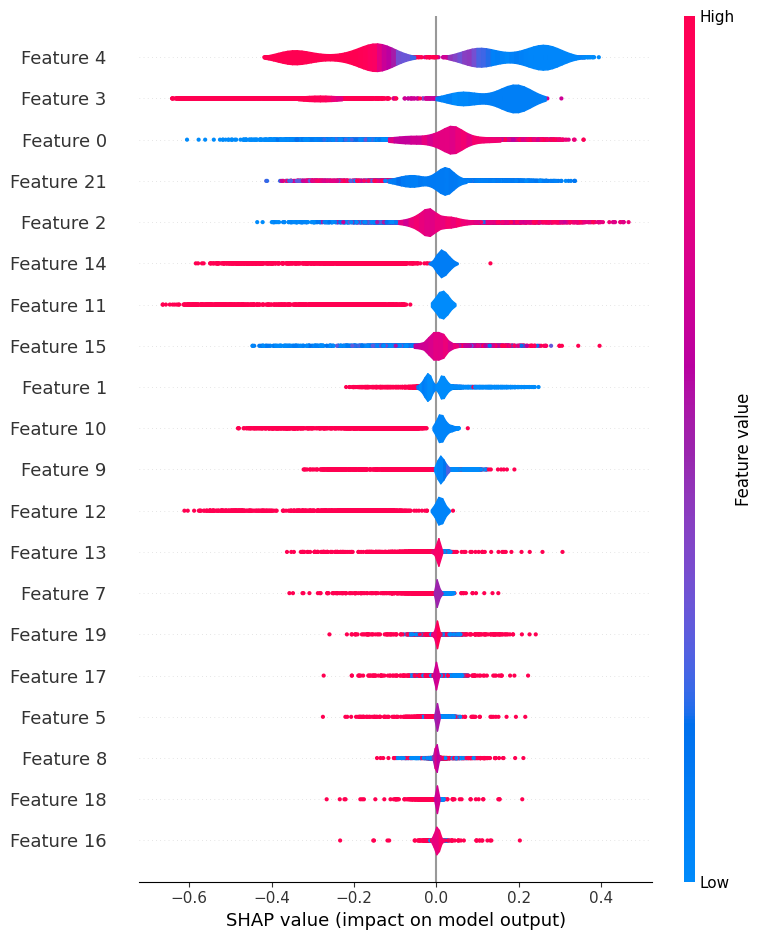

{'Accuracy': 0.804023049834596,
 'Precision': 0.7800397219463754,
 'Recall': 0.8434446472672609,
 'F1 Score': 0.8105040499406696}

In [ ]:
#project done 28/06 our best
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(dataframe, independent_var):

    X = dataframe.drop([independent_var, 'Total CM', 'Total PM25', 'Total NOx', 'Total SO', 'br002_', 'br001_', 'ph011d3',
                          'ph048d2', 'ph049d9', 'ph048d3', 'ph049d1', 'ph049d3', 'ph049d4', 'ph011d11',
                          'ph049d5', 'ph049d10', 'ph049d11', 'ph049d6', 'ph049d2', 'ph011d2', 'ph011d1', 'ph011d6',
                          'ph049d8', 'ph011d13', 'ph011d14', 'ph011d7', 'ph011d9', 'ph048d10', 'ph048d7', 'ph048d8',
                          'ph048d9', 'ph049d12', 'ph049d7'], axis=1)
    y = dataframe[independent_var]

    print(X)

    # apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Min-Max normalization
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X_resampled)

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_resampled, test_size=0.2, random_state=42)

    # create a random forest classifier with regularization
    model = RandomForestClassifier(random_state=42, max_depth=10)

    # parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [64, 100, 128, 200],
        'max_features': [2, 3, 5, 7],
        'bootstrap': [True, False],
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Check for overfitting
    train_predictions = best_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_f1 = f1_score(y_train, train_predictions)

    test_predictions = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_f1 = f1_score(y_test, test_predictions)

    print("Train Accuracy:", train_accuracy)
    print("Train F1 Score:", train_f1)
    print("Test Accuracy:", test_accuracy)
    print("Test F1 Score:", test_f1)

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(confusion_matrix(y_test, y_pred))
    print('-' * 60)
    print(classification_report(y_test, y_pred))

    # get feature importances
    feature_importances = best_model.feature_importances_
    coef_dict = {}
    for i in range(len(X.columns)):
        coef_dict[X.columns[i]] = feature_importances[i]

    # sort the feature importances in descending order
    sorted_coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: abs(item[1]), reverse=True)}

    print(sorted_coef_dict)

    import shap
    # Fits the explainer
    explainer = shap.Explainer(best_model.predict, X_test)
    # Calculates the SHAP values
    shap_values = explainer(X_test)

    # Plotting SHAP summary plot
    shap.summary_plot(shap_values, plot_type='violin')


    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

evaluate_model(s_stroke, 'ph006d4')
